This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import f_oneway as anova
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# set the path to the data
sum_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/sum_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
sum_aggregated_data_pca = pd.read_parquet(sum_aggregated_data_pca_path)
print(sum_aggregated_data_pca.shape)
sum_aggregated_data_pca.head()

(83, 86)


,Metadata_genotype,Metadata_replicate,Metadata_side,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83
0,High-Severity,1,L,-4.119483,1.991218,0.303879,-1.684469,2.612682,-3.209001,3.797245,...,-0.024596,-0.135772,-0.032539,-0.117004,0.379927,0.055097,0.020213,0.171419,-0.038079,-2.315274e-16
1,High-Severity,1,R,-0.216856,-6.465370,1.138630,-1.419515,0.734994,0.286382,-1.947202,...,0.352484,0.491001,0.066891,-0.412823,0.171996,-0.254966,-0.137621,0.301330,-0.202659,-1.327045e-15
2,High-Severity,10,L,3.037171,-9.309422,2.331700,-2.247219,-1.799904,1.185632,-2.196101,...,-0.091030,-0.036167,-0.421525,0.309394,-0.645142,-0.057501,-0.154886,-0.185996,-0.299166,-2.523921e-15
3,High-Severity,10,R,0.812527,-5.060089,2.102814,0.003530,-0.285134,1.160509,-2.081840,...,0.249178,-0.249715,0.443153,-0.144278,-0.577923,-0.062862,0.625753,-0.223723,0.165455,-1.249731e-15
4,High-Severity,11,L,0.186089,-8.703921,0.058820,-1.604671,2.038516,-2.165193,4.044708,...,0.143239,-0.143268,-0.037719,-0.108338,-0.290040,0.009491,0.024692,-0.036455,0.050904,9.182966e-16


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA 
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

28 27 28


In [4]:
# drop the the Metadata columns
metadata_columns = high_severity.columns[high_severity.columns.str.contains("Metadata")]
high_severity = high_severity.drop(metadata_columns, axis=1)
low_severity = low_severity.drop(metadata_columns, axis=1)
wt = wt.drop(metadata_columns, axis=1)


# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(28, 83) (27, 83) (28, 83)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 13.454875980757157


/home/lippincm/miniforge3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 12.876674389086938


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 8.917734153240842


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                          | 1/1000 [00:00<02:50,  5.87it/s]

  0%|                                                          | 2/1000 [00:00<02:52,  5.78it/s]

  0%|▏                                                         | 3/1000 [00:00<02:51,  5.80it/s]

  0%|▏                                                         | 4/1000 [00:00<03:10,  5.22it/s]

  0%|▎                                                         | 5/1000 [00:00<03:22,  4.92it/s]

  1%|▎                                                         | 6/1000 [00:01<03:12,  5.16it/s]

  1%|▍                                                         | 7/1000 [00:01<03:14,  5.12it/s]

  1%|▍                                                         | 8/1000 [00:01<03:12,  5.16it/s]

  1%|▌                                                         | 9/1000 [00:01<03:09,  5.24it/s]

  1%|▌                                                        | 10/1000 [00:01<03:10,  5.20it/s]

  1%|▋                                                        | 11/1000 [00:02<03:04,  5.35it/s]

  1%|▋                                                        | 12/1000 [00:02<03:14,  5.08it/s]

  1%|▋                                                        | 13/1000 [00:02<03:07,  5.27it/s]

  1%|▊                                                        | 14/1000 [00:02<03:03,  5.38it/s]

  2%|▊                                                        | 15/1000 [00:02<02:59,  5.49it/s]

  2%|▉                                                        | 16/1000 [00:02<02:56,  5.57it/s]

  2%|▉                                                        | 17/1000 [00:03<02:54,  5.62it/s]

  2%|█                                                        | 18/1000 [00:03<02:52,  5.68it/s]

  2%|█                                                        | 19/1000 [00:03<02:52,  5.69it/s]

  2%|█▏                                                       | 20/1000 [00:03<02:53,  5.66it/s]

  2%|█▏                                                       | 21/1000 [00:03<02:53,  5.64it/s]

  2%|█▎                                                       | 22/1000 [00:04<02:53,  5.65it/s]

  2%|█▎                                                       | 23/1000 [00:04<02:54,  5.60it/s]

  2%|█▎                                                       | 24/1000 [00:04<02:54,  5.61it/s]

  2%|█▍                                                       | 25/1000 [00:04<02:57,  5.49it/s]

  3%|█▍                                                       | 26/1000 [00:04<03:04,  5.27it/s]

  3%|█▌                                                       | 27/1000 [00:04<03:00,  5.39it/s]

  3%|█▌                                                       | 28/1000 [00:05<02:56,  5.49it/s]

  3%|█▋                                                       | 29/1000 [00:05<02:55,  5.54it/s]

  3%|█▋                                                       | 30/1000 [00:05<02:54,  5.55it/s]

  3%|█▊                                                       | 31/1000 [00:05<02:55,  5.53it/s]

  3%|█▊                                                       | 32/1000 [00:05<02:53,  5.56it/s]

  3%|█▉                                                       | 33/1000 [00:06<03:09,  5.09it/s]

  3%|█▉                                                       | 34/1000 [00:06<03:03,  5.27it/s]

  4%|█▉                                                       | 35/1000 [00:06<02:58,  5.41it/s]

  4%|██                                                       | 36/1000 [00:06<02:55,  5.49it/s]

  4%|██                                                       | 37/1000 [00:06<03:06,  5.17it/s]

  4%|██▏                                                      | 38/1000 [00:07<02:59,  5.35it/s]

  4%|██▏                                                      | 39/1000 [00:07<02:55,  5.47it/s]

  4%|██▎                                                      | 40/1000 [00:07<02:55,  5.45it/s]

  4%|██▎                                                      | 41/1000 [00:07<02:52,  5.55it/s]

  4%|██▍                                                      | 42/1000 [00:07<02:50,  5.61it/s]

  4%|██▍                                                      | 43/1000 [00:07<02:49,  5.63it/s]

  4%|██▌                                                      | 44/1000 [00:08<02:50,  5.62it/s]

  4%|██▌                                                      | 45/1000 [00:08<02:50,  5.61it/s]

  5%|██▌                                                      | 46/1000 [00:08<02:48,  5.66it/s]

  5%|██▋                                                      | 47/1000 [00:08<02:47,  5.68it/s]

  5%|██▋                                                      | 48/1000 [00:08<02:46,  5.71it/s]

  5%|██▊                                                      | 49/1000 [00:08<02:46,  5.69it/s]

  5%|██▊                                                      | 50/1000 [00:09<02:45,  5.73it/s]

  5%|██▉                                                      | 51/1000 [00:09<02:45,  5.75it/s]

  5%|██▉                                                      | 52/1000 [00:09<02:41,  5.86it/s]

  5%|███                                                      | 53/1000 [00:09<02:49,  5.58it/s]

  5%|███                                                      | 54/1000 [00:09<02:48,  5.61it/s]

  6%|███▏                                                     | 55/1000 [00:10<02:49,  5.56it/s]

  6%|███▏                                                     | 56/1000 [00:10<02:50,  5.53it/s]

  6%|███▏                                                     | 57/1000 [00:10<02:48,  5.60it/s]

  6%|███▎                                                     | 58/1000 [00:10<02:47,  5.63it/s]

  6%|███▎                                                     | 59/1000 [00:10<02:48,  5.60it/s]

  6%|███▍                                                     | 60/1000 [00:10<02:47,  5.63it/s]

  6%|███▍                                                     | 61/1000 [00:11<02:46,  5.65it/s]

  6%|███▌                                                     | 62/1000 [00:11<02:46,  5.64it/s]

  6%|███▌                                                     | 63/1000 [00:11<02:48,  5.56it/s]

  6%|███▋                                                     | 64/1000 [00:11<02:47,  5.60it/s]

  6%|███▋                                                     | 65/1000 [00:11<02:46,  5.63it/s]

  7%|███▊                                                     | 66/1000 [00:11<02:44,  5.67it/s]

  7%|███▊                                                     | 67/1000 [00:12<03:00,  5.17it/s]

  7%|███▉                                                     | 68/1000 [00:12<02:57,  5.25it/s]

  7%|███▉                                                     | 69/1000 [00:12<02:52,  5.40it/s]

  7%|███▉                                                     | 70/1000 [00:12<02:49,  5.48it/s]

  7%|████                                                     | 71/1000 [00:12<02:47,  5.54it/s]

  7%|████                                                     | 72/1000 [00:13<02:45,  5.59it/s]

  7%|████▏                                                    | 73/1000 [00:13<02:44,  5.65it/s]

  7%|████▏                                                    | 74/1000 [00:13<02:43,  5.65it/s]

  8%|████▎                                                    | 75/1000 [00:13<02:43,  5.66it/s]

  8%|████▎                                                    | 76/1000 [00:13<02:43,  5.64it/s]

  8%|████▍                                                    | 77/1000 [00:13<02:43,  5.65it/s]

  8%|████▍                                                    | 78/1000 [00:14<02:43,  5.63it/s]

  8%|████▌                                                    | 79/1000 [00:14<02:55,  5.24it/s]

  8%|████▌                                                    | 80/1000 [00:14<02:51,  5.36it/s]

  8%|████▌                                                    | 81/1000 [00:14<02:48,  5.45it/s]

  8%|████▋                                                    | 82/1000 [00:14<02:46,  5.51it/s]

  8%|████▋                                                    | 83/1000 [00:15<02:54,  5.26it/s]

  8%|████▊                                                    | 84/1000 [00:15<02:50,  5.38it/s]

  8%|████▊                                                    | 85/1000 [00:15<02:46,  5.50it/s]

  9%|████▉                                                    | 86/1000 [00:15<02:44,  5.55it/s]

  9%|████▉                                                    | 87/1000 [00:15<02:43,  5.57it/s]

  9%|█████                                                    | 88/1000 [00:16<02:55,  5.21it/s]

  9%|█████                                                    | 89/1000 [00:16<02:50,  5.35it/s]

  9%|█████▏                                                   | 90/1000 [00:16<02:47,  5.43it/s]

  9%|█████▏                                                   | 91/1000 [00:16<02:45,  5.51it/s]

  9%|█████▏                                                   | 92/1000 [00:16<02:47,  5.42it/s]

  9%|█████▎                                                   | 93/1000 [00:16<02:44,  5.53it/s]

  9%|█████▎                                                   | 94/1000 [00:17<02:42,  5.59it/s]

 10%|█████▍                                                   | 95/1000 [00:17<02:40,  5.63it/s]

 10%|█████▍                                                   | 96/1000 [00:17<02:40,  5.65it/s]

 10%|█████▌                                                   | 97/1000 [00:17<02:45,  5.45it/s]

 10%|█████▌                                                   | 98/1000 [00:17<02:44,  5.50it/s]

 10%|█████▋                                                   | 99/1000 [00:18<02:41,  5.57it/s]

 10%|█████▌                                                  | 100/1000 [00:18<02:41,  5.57it/s]

 10%|█████▋                                                  | 101/1000 [00:18<02:39,  5.62it/s]

 10%|█████▋                                                  | 102/1000 [00:18<02:39,  5.65it/s]

 10%|█████▊                                                  | 103/1000 [00:18<02:38,  5.65it/s]

 10%|█████▊                                                  | 104/1000 [00:18<02:38,  5.65it/s]

 10%|█████▉                                                  | 105/1000 [00:19<02:37,  5.68it/s]

 11%|█████▉                                                  | 106/1000 [00:19<02:41,  5.52it/s]

 11%|█████▉                                                  | 107/1000 [00:19<02:45,  5.39it/s]

 11%|██████                                                  | 108/1000 [00:19<02:42,  5.48it/s]

 11%|██████                                                  | 109/1000 [00:19<02:40,  5.54it/s]

 11%|██████▏                                                 | 110/1000 [00:19<02:39,  5.58it/s]

 11%|██████▏                                                 | 111/1000 [00:20<02:38,  5.60it/s]

 11%|██████▎                                                 | 112/1000 [00:20<02:37,  5.65it/s]

 11%|██████▎                                                 | 113/1000 [00:20<02:37,  5.62it/s]

 11%|██████▍                                                 | 114/1000 [00:20<02:36,  5.66it/s]

 12%|██████▍                                                 | 115/1000 [00:20<02:44,  5.38it/s]

 12%|██████▍                                                 | 116/1000 [00:21<02:42,  5.44it/s]

 12%|██████▌                                                 | 117/1000 [00:21<02:39,  5.53it/s]

 12%|██████▌                                                 | 118/1000 [00:21<02:38,  5.55it/s]

 12%|██████▋                                                 | 119/1000 [00:21<02:37,  5.58it/s]

 12%|██████▋                                                 | 120/1000 [00:21<02:47,  5.25it/s]

 12%|██████▊                                                 | 121/1000 [00:21<02:44,  5.34it/s]

 12%|██████▊                                                 | 122/1000 [00:22<02:40,  5.45it/s]

 12%|██████▉                                                 | 123/1000 [00:22<02:38,  5.52it/s]

 12%|██████▉                                                 | 124/1000 [00:22<02:37,  5.58it/s]

 12%|███████                                                 | 125/1000 [00:22<02:36,  5.61it/s]

 13%|███████                                                 | 126/1000 [00:22<02:36,  5.59it/s]

 13%|███████                                                 | 127/1000 [00:23<02:45,  5.28it/s]

 13%|███████▏                                                | 128/1000 [00:23<02:39,  5.48it/s]

 13%|███████▏                                                | 129/1000 [00:23<02:40,  5.41it/s]

 13%|███████▎                                                | 130/1000 [00:23<02:38,  5.47it/s]

 13%|███████▎                                                | 131/1000 [00:23<02:36,  5.56it/s]

 13%|███████▍                                                | 132/1000 [00:23<02:35,  5.59it/s]

 13%|███████▍                                                | 133/1000 [00:24<02:39,  5.44it/s]

 13%|███████▌                                                | 134/1000 [00:24<02:43,  5.28it/s]

 14%|███████▌                                                | 135/1000 [00:24<02:41,  5.35it/s]

 14%|███████▌                                                | 136/1000 [00:24<02:38,  5.45it/s]

 14%|███████▋                                                | 137/1000 [00:24<02:36,  5.50it/s]

 14%|███████▋                                                | 138/1000 [00:25<02:35,  5.55it/s]

 14%|███████▊                                                | 139/1000 [00:25<02:33,  5.62it/s]

 14%|███████▊                                                | 140/1000 [00:25<02:32,  5.64it/s]

 14%|███████▉                                                | 141/1000 [00:25<02:50,  5.05it/s]

 14%|███████▉                                                | 142/1000 [00:25<02:44,  5.23it/s]

 14%|████████                                                | 143/1000 [00:26<02:39,  5.36it/s]

 14%|████████                                                | 144/1000 [00:26<02:37,  5.43it/s]

 14%|████████                                                | 145/1000 [00:26<02:34,  5.53it/s]

 15%|████████▏                                               | 146/1000 [00:26<02:34,  5.53it/s]

 15%|████████▏                                               | 147/1000 [00:26<02:32,  5.60it/s]

 15%|████████▎                                               | 148/1000 [00:26<02:31,  5.62it/s]

 15%|████████▎                                               | 149/1000 [00:27<02:30,  5.66it/s]

 15%|████████▍                                               | 150/1000 [00:27<02:35,  5.47it/s]

 15%|████████▍                                               | 151/1000 [00:27<02:34,  5.51it/s]

 15%|████████▌                                               | 152/1000 [00:27<02:32,  5.56it/s]

 15%|████████▌                                               | 153/1000 [00:27<02:31,  5.59it/s]

 15%|████████▌                                               | 154/1000 [00:27<02:30,  5.62it/s]

 16%|████████▋                                               | 155/1000 [00:28<02:29,  5.67it/s]

 16%|████████▋                                               | 156/1000 [00:28<02:36,  5.39it/s]

 16%|████████▊                                               | 157/1000 [00:28<02:34,  5.45it/s]

 16%|████████▊                                               | 158/1000 [00:28<02:32,  5.51it/s]

 16%|████████▉                                               | 159/1000 [00:28<02:31,  5.57it/s]

 16%|████████▉                                               | 160/1000 [00:29<02:30,  5.58it/s]

 16%|█████████                                               | 161/1000 [00:29<02:29,  5.63it/s]

 16%|█████████                                               | 162/1000 [00:29<02:29,  5.62it/s]

 16%|█████████▏                                              | 163/1000 [00:29<02:28,  5.63it/s]

 16%|█████████▏                                              | 164/1000 [00:29<02:34,  5.40it/s]

 16%|█████████▏                                              | 165/1000 [00:29<02:32,  5.47it/s]

 17%|█████████▎                                              | 166/1000 [00:30<02:32,  5.47it/s]

 17%|█████████▎                                              | 167/1000 [00:30<02:30,  5.52it/s]

 17%|█████████▍                                              | 168/1000 [00:30<02:41,  5.15it/s]

 17%|█████████▍                                              | 169/1000 [00:30<02:43,  5.09it/s]

 17%|█████████▌                                              | 170/1000 [00:30<02:37,  5.28it/s]

 17%|█████████▌                                              | 171/1000 [00:31<02:33,  5.41it/s]

 17%|█████████▋                                              | 172/1000 [00:31<02:30,  5.50it/s]

 17%|█████████▋                                              | 173/1000 [00:31<02:29,  5.52it/s]

 17%|█████████▋                                              | 174/1000 [00:31<02:28,  5.54it/s]

 18%|█████████▊                                              | 175/1000 [00:31<02:27,  5.60it/s]

 18%|█████████▊                                              | 176/1000 [00:32<02:38,  5.20it/s]

 18%|█████████▉                                              | 177/1000 [00:32<02:34,  5.32it/s]

 18%|█████████▉                                              | 178/1000 [00:32<02:31,  5.43it/s]

 18%|██████████                                              | 179/1000 [00:32<02:29,  5.51it/s]

 18%|██████████                                              | 180/1000 [00:32<02:27,  5.56it/s]

 18%|██████████▏                                             | 181/1000 [00:32<02:25,  5.63it/s]

 18%|██████████▏                                             | 182/1000 [00:33<02:24,  5.65it/s]

 18%|██████████▏                                             | 183/1000 [00:33<02:23,  5.68it/s]

 18%|██████████▎                                             | 184/1000 [00:33<02:23,  5.68it/s]

 18%|██████████▎                                             | 185/1000 [00:33<02:24,  5.66it/s]

 19%|██████████▍                                             | 186/1000 [00:33<02:23,  5.67it/s]

 19%|██████████▍                                             | 187/1000 [00:33<02:24,  5.64it/s]

 19%|██████████▌                                             | 188/1000 [00:34<02:24,  5.62it/s]

 19%|██████████▌                                             | 189/1000 [00:34<02:27,  5.48it/s]

 19%|██████████▋                                             | 190/1000 [00:34<02:26,  5.52it/s]

 19%|██████████▋                                             | 191/1000 [00:34<02:24,  5.59it/s]

 19%|██████████▊                                             | 192/1000 [00:34<02:23,  5.63it/s]

 19%|██████████▊                                             | 193/1000 [00:35<02:23,  5.63it/s]

 19%|██████████▊                                             | 194/1000 [00:35<02:28,  5.45it/s]

 20%|██████████▉                                             | 195/1000 [00:35<02:26,  5.48it/s]

 20%|██████████▉                                             | 196/1000 [00:35<02:24,  5.55it/s]

 20%|███████████                                             | 197/1000 [00:35<02:24,  5.54it/s]

 20%|███████████                                             | 198/1000 [00:35<02:23,  5.60it/s]

 20%|███████████▏                                            | 199/1000 [00:36<02:22,  5.63it/s]

 20%|███████████▏                                            | 200/1000 [00:36<02:18,  5.78it/s]

 20%|███████████▎                                            | 201/1000 [00:36<02:29,  5.36it/s]

 20%|███████████▎                                            | 202/1000 [00:36<02:42,  4.92it/s]

 20%|███████████▎                                            | 203/1000 [00:37<03:02,  4.36it/s]

 20%|███████████▍                                            | 204/1000 [00:37<03:19,  4.00it/s]

 20%|███████████▍                                            | 205/1000 [00:37<03:15,  4.06it/s]

 21%|███████████▌                                            | 206/1000 [00:37<03:09,  4.20it/s]

 21%|███████████▌                                            | 207/1000 [00:37<02:54,  4.55it/s]

 21%|███████████▋                                            | 208/1000 [00:38<02:48,  4.70it/s]

 21%|███████████▋                                            | 209/1000 [00:38<02:39,  4.96it/s]

 21%|███████████▊                                            | 210/1000 [00:38<02:32,  5.18it/s]

 21%|███████████▊                                            | 211/1000 [00:38<02:28,  5.32it/s]

 21%|███████████▊                                            | 212/1000 [00:38<02:25,  5.43it/s]

 21%|███████████▉                                            | 213/1000 [00:39<02:34,  5.10it/s]

 21%|███████████▉                                            | 214/1000 [00:39<02:29,  5.27it/s]

 22%|████████████                                            | 215/1000 [00:39<02:28,  5.30it/s]

 22%|████████████                                            | 216/1000 [00:39<02:24,  5.41it/s]

 22%|████████████▏                                           | 217/1000 [00:39<02:21,  5.52it/s]

 22%|████████████▏                                           | 218/1000 [00:40<02:33,  5.10it/s]

 22%|████████████▎                                           | 219/1000 [00:40<02:35,  5.03it/s]

 22%|████████████▎                                           | 220/1000 [00:40<02:29,  5.22it/s]

 22%|████████████▍                                           | 221/1000 [00:40<02:25,  5.36it/s]

 22%|████████████▍                                           | 222/1000 [00:40<02:37,  4.95it/s]

 22%|████████████▍                                           | 223/1000 [00:41<02:44,  4.73it/s]

 22%|████████████▌                                           | 224/1000 [00:41<02:37,  4.93it/s]

 22%|████████████▌                                           | 225/1000 [00:41<02:43,  4.74it/s]

 23%|████████████▋                                           | 226/1000 [00:41<02:37,  4.92it/s]

 23%|████████████▋                                           | 227/1000 [00:41<02:32,  5.07it/s]

 23%|████████████▊                                           | 228/1000 [00:42<02:29,  5.18it/s]

 23%|████████████▊                                           | 229/1000 [00:42<02:24,  5.35it/s]

 23%|████████████▉                                           | 230/1000 [00:42<02:21,  5.46it/s]

 23%|████████████▉                                           | 231/1000 [00:42<02:29,  5.14it/s]

 23%|████████████▉                                           | 232/1000 [00:42<02:26,  5.24it/s]

 23%|█████████████                                           | 233/1000 [00:43<02:32,  5.04it/s]

 23%|█████████████                                           | 234/1000 [00:43<02:42,  4.71it/s]

 24%|█████████████▏                                          | 235/1000 [00:43<02:33,  4.98it/s]

 24%|█████████████▏                                          | 236/1000 [00:43<02:31,  5.06it/s]

 24%|█████████████▎                                          | 237/1000 [00:43<02:26,  5.21it/s]

 24%|█████████████▎                                          | 238/1000 [00:43<02:23,  5.32it/s]

 24%|█████████████▍                                          | 239/1000 [00:44<02:23,  5.29it/s]

 24%|█████████████▍                                          | 240/1000 [00:44<02:24,  5.27it/s]

 24%|█████████████▍                                          | 241/1000 [00:44<02:20,  5.42it/s]

 24%|█████████████▌                                          | 242/1000 [00:44<02:18,  5.48it/s]

 24%|█████████████▌                                          | 243/1000 [00:44<02:19,  5.42it/s]

 24%|█████████████▋                                          | 244/1000 [00:45<02:23,  5.28it/s]

 24%|█████████████▋                                          | 245/1000 [00:45<02:22,  5.31it/s]

 25%|█████████████▊                                          | 246/1000 [00:45<02:31,  4.98it/s]

 25%|█████████████▊                                          | 247/1000 [00:45<02:26,  5.13it/s]

 25%|█████████████▉                                          | 248/1000 [00:45<02:19,  5.40it/s]

 25%|█████████████▉                                          | 249/1000 [00:46<02:16,  5.48it/s]

 25%|██████████████                                          | 250/1000 [00:46<02:15,  5.53it/s]

 25%|██████████████                                          | 251/1000 [00:46<02:18,  5.42it/s]

 25%|██████████████                                          | 252/1000 [00:46<02:16,  5.49it/s]

 25%|██████████████▏                                         | 253/1000 [00:46<02:31,  4.93it/s]

 25%|██████████████▏                                         | 254/1000 [00:47<02:27,  5.06it/s]

 26%|██████████████▎                                         | 255/1000 [00:47<02:22,  5.23it/s]

 26%|██████████████▎                                         | 256/1000 [00:47<02:20,  5.30it/s]

 26%|██████████████▍                                         | 257/1000 [00:47<02:18,  5.36it/s]

 26%|██████████████▍                                         | 258/1000 [00:47<02:20,  5.29it/s]

 26%|██████████████▌                                         | 259/1000 [00:47<02:22,  5.20it/s]

 26%|██████████████▌                                         | 260/1000 [00:48<02:18,  5.35it/s]

 26%|██████████████▌                                         | 261/1000 [00:48<02:28,  4.98it/s]

 26%|██████████████▋                                         | 262/1000 [00:48<02:27,  5.01it/s]

 26%|██████████████▋                                         | 263/1000 [00:48<02:20,  5.24it/s]

 26%|██████████████▊                                         | 264/1000 [00:48<02:17,  5.35it/s]

 26%|██████████████▊                                         | 265/1000 [00:49<02:16,  5.40it/s]

 27%|██████████████▉                                         | 266/1000 [00:49<02:13,  5.50it/s]

 27%|██████████████▉                                         | 267/1000 [00:49<02:11,  5.58it/s]

 27%|███████████████                                         | 268/1000 [00:49<02:20,  5.21it/s]

 27%|███████████████                                         | 269/1000 [00:49<02:16,  5.34it/s]

 27%|███████████████                                         | 270/1000 [00:50<02:14,  5.42it/s]

 27%|███████████████▏                                        | 271/1000 [00:50<02:12,  5.50it/s]

 27%|███████████████▏                                        | 272/1000 [00:50<02:10,  5.57it/s]

 27%|███████████████▎                                        | 273/1000 [00:50<02:14,  5.41it/s]

 27%|███████████████▎                                        | 274/1000 [00:50<02:11,  5.53it/s]

 28%|███████████████▍                                        | 275/1000 [00:50<02:14,  5.40it/s]

 28%|███████████████▍                                        | 276/1000 [00:51<02:12,  5.45it/s]

 28%|███████████████▌                                        | 277/1000 [00:51<02:12,  5.47it/s]

 28%|███████████████▌                                        | 278/1000 [00:51<02:13,  5.41it/s]

 28%|███████████████▌                                        | 279/1000 [00:51<02:11,  5.48it/s]

 28%|███████████████▋                                        | 280/1000 [00:51<02:22,  5.04it/s]

 28%|███████████████▋                                        | 281/1000 [00:52<02:17,  5.22it/s]

 28%|███████████████▊                                        | 282/1000 [00:52<02:14,  5.33it/s]

 28%|███████████████▊                                        | 283/1000 [00:52<02:11,  5.44it/s]

 28%|███████████████▉                                        | 284/1000 [00:52<02:09,  5.52it/s]

 28%|███████████████▉                                        | 285/1000 [00:52<02:13,  5.35it/s]

 29%|████████████████                                        | 286/1000 [00:52<02:10,  5.46it/s]

 29%|████████████████                                        | 287/1000 [00:53<02:22,  5.02it/s]

 29%|████████████████▏                                       | 288/1000 [00:53<02:27,  4.84it/s]

 29%|████████████████▏                                       | 289/1000 [00:53<02:20,  5.08it/s]

 29%|████████████████▏                                       | 290/1000 [00:53<02:17,  5.16it/s]

 29%|████████████████▎                                       | 291/1000 [00:53<02:13,  5.31it/s]

 29%|████████████████▎                                       | 292/1000 [00:54<02:10,  5.41it/s]

 29%|████████████████▍                                       | 293/1000 [00:54<02:08,  5.49it/s]

 29%|████████████████▍                                       | 294/1000 [00:54<02:09,  5.46it/s]

 30%|████████████████▌                                       | 295/1000 [00:54<02:08,  5.49it/s]

 30%|████████████████▌                                       | 296/1000 [00:54<02:06,  5.55it/s]

 30%|████████████████▋                                       | 297/1000 [00:55<02:19,  5.06it/s]

 30%|████████████████▋                                       | 298/1000 [00:55<02:14,  5.20it/s]

 30%|████████████████▋                                       | 299/1000 [00:55<02:11,  5.34it/s]

 30%|████████████████▊                                       | 300/1000 [00:55<02:08,  5.44it/s]

 30%|████████████████▊                                       | 301/1000 [00:55<02:07,  5.49it/s]

 30%|████████████████▉                                       | 302/1000 [00:56<02:19,  5.00it/s]

 30%|████████████████▉                                       | 303/1000 [00:56<02:15,  5.13it/s]

 30%|█████████████████                                       | 304/1000 [00:56<02:11,  5.28it/s]

 30%|█████████████████                                       | 305/1000 [00:56<02:09,  5.36it/s]

 31%|█████████████████▏                                      | 306/1000 [00:56<02:16,  5.09it/s]

 31%|█████████████████▏                                      | 307/1000 [00:57<02:23,  4.84it/s]

 31%|█████████████████▏                                      | 308/1000 [00:57<02:16,  5.07it/s]

 31%|█████████████████▎                                      | 309/1000 [00:57<02:11,  5.24it/s]

 31%|█████████████████▎                                      | 310/1000 [00:57<02:08,  5.36it/s]

 31%|█████████████████▍                                      | 311/1000 [00:57<02:05,  5.47it/s]

 31%|█████████████████▍                                      | 312/1000 [00:57<02:04,  5.53it/s]

 31%|█████████████████▌                                      | 313/1000 [00:58<02:02,  5.59it/s]

 31%|█████████████████▌                                      | 314/1000 [00:58<02:18,  4.96it/s]

 32%|█████████████████▋                                      | 315/1000 [00:58<02:13,  5.14it/s]

 32%|█████████████████▋                                      | 316/1000 [00:58<02:09,  5.29it/s]

 32%|█████████████████▊                                      | 317/1000 [00:58<02:12,  5.16it/s]

 32%|█████████████████▊                                      | 318/1000 [00:59<02:09,  5.27it/s]

 32%|█████████████████▊                                      | 319/1000 [00:59<02:13,  5.12it/s]

 32%|█████████████████▉                                      | 320/1000 [00:59<02:13,  5.11it/s]

 32%|█████████████████▉                                      | 321/1000 [00:59<02:08,  5.27it/s]

 32%|██████████████████                                      | 322/1000 [00:59<02:23,  4.72it/s]

 32%|██████████████████                                      | 323/1000 [01:00<02:16,  4.95it/s]

 32%|██████████████████▏                                     | 324/1000 [01:00<02:15,  4.99it/s]

 32%|██████████████████▏                                     | 325/1000 [01:00<02:22,  4.74it/s]

 33%|██████████████████▎                                     | 326/1000 [01:00<02:15,  4.97it/s]

 33%|██████████████████▎                                     | 327/1000 [01:00<02:11,  5.12it/s]

 33%|██████████████████▎                                     | 328/1000 [01:01<02:10,  5.16it/s]

 33%|██████████████████▍                                     | 329/1000 [01:01<02:05,  5.37it/s]

 33%|██████████████████▍                                     | 330/1000 [01:01<02:19,  4.82it/s]

 33%|██████████████████▌                                     | 331/1000 [01:01<02:12,  5.06it/s]

 33%|██████████████████▌                                     | 332/1000 [01:01<02:08,  5.18it/s]

 33%|██████████████████▋                                     | 333/1000 [01:02<02:04,  5.35it/s]

 33%|██████████████████▋                                     | 334/1000 [01:02<02:01,  5.47it/s]

 34%|██████████████████▊                                     | 335/1000 [01:02<02:01,  5.47it/s]

 34%|██████████████████▊                                     | 336/1000 [01:02<01:59,  5.56it/s]

 34%|██████████████████▊                                     | 337/1000 [01:02<02:00,  5.50it/s]

 34%|██████████████████▉                                     | 338/1000 [01:02<01:58,  5.58it/s]

 34%|██████████████████▉                                     | 339/1000 [01:03<02:08,  5.13it/s]

 34%|███████████████████                                     | 340/1000 [01:03<02:04,  5.29it/s]

 34%|███████████████████                                     | 341/1000 [01:03<02:01,  5.42it/s]

 34%|███████████████████▏                                    | 342/1000 [01:03<02:09,  5.08it/s]

 34%|███████████████████▏                                    | 343/1000 [01:03<02:05,  5.21it/s]

 34%|███████████████████▎                                    | 344/1000 [01:04<02:01,  5.39it/s]

 34%|███████████████████▎                                    | 345/1000 [01:04<01:59,  5.46it/s]

 35%|███████████████████▍                                    | 346/1000 [01:04<01:58,  5.54it/s]

 35%|███████████████████▍                                    | 347/1000 [01:04<01:56,  5.60it/s]

 35%|███████████████████▍                                    | 348/1000 [01:04<02:05,  5.20it/s]

 35%|███████████████████▌                                    | 349/1000 [01:05<02:16,  4.77it/s]

 35%|███████████████████▌                                    | 350/1000 [01:05<02:20,  4.62it/s]

 35%|███████████████████▋                                    | 351/1000 [01:05<02:12,  4.90it/s]

 35%|███████████████████▋                                    | 352/1000 [01:05<02:07,  5.10it/s]

 35%|███████████████████▊                                    | 353/1000 [01:05<02:07,  5.06it/s]

 35%|███████████████████▊                                    | 354/1000 [01:06<02:03,  5.23it/s]

 36%|███████████████████▉                                    | 355/1000 [01:06<02:01,  5.33it/s]

 36%|███████████████████▉                                    | 356/1000 [01:06<01:58,  5.43it/s]

 36%|███████████████████▉                                    | 357/1000 [01:06<02:02,  5.27it/s]

 36%|████████████████████                                    | 358/1000 [01:06<01:59,  5.38it/s]

 36%|████████████████████                                    | 359/1000 [01:06<01:57,  5.46it/s]

 36%|████████████████████▏                                   | 360/1000 [01:07<01:57,  5.43it/s]

 36%|████████████████████▏                                   | 361/1000 [01:07<01:56,  5.48it/s]

 36%|████████████████████▎                                   | 362/1000 [01:07<02:05,  5.08it/s]

 36%|████████████████████▎                                   | 363/1000 [01:07<02:01,  5.25it/s]

 36%|████████████████████▍                                   | 364/1000 [01:07<01:59,  5.33it/s]

 36%|████████████████████▍                                   | 365/1000 [01:08<02:02,  5.20it/s]

 37%|████████████████████▍                                   | 366/1000 [01:08<01:58,  5.34it/s]

 37%|████████████████████▌                                   | 367/1000 [01:08<01:56,  5.43it/s]

 37%|████████████████████▌                                   | 368/1000 [01:08<01:55,  5.48it/s]

 37%|████████████████████▋                                   | 369/1000 [01:08<02:07,  4.95it/s]

 37%|████████████████████▋                                   | 370/1000 [01:09<02:03,  5.12it/s]

 37%|████████████████████▊                                   | 371/1000 [01:09<01:59,  5.27it/s]

 37%|████████████████████▊                                   | 372/1000 [01:09<02:02,  5.11it/s]

 37%|████████████████████▉                                   | 373/1000 [01:09<01:58,  5.28it/s]

 37%|████████████████████▉                                   | 374/1000 [01:09<01:55,  5.42it/s]

 38%|█████████████████████                                   | 375/1000 [01:09<01:53,  5.52it/s]

 38%|█████████████████████                                   | 376/1000 [01:10<01:52,  5.54it/s]

 38%|█████████████████████                                   | 377/1000 [01:10<02:04,  4.99it/s]

 38%|█████████████████████▏                                  | 378/1000 [01:10<02:00,  5.18it/s]

 38%|█████████████████████▏                                  | 379/1000 [01:10<02:07,  4.86it/s]

 38%|█████████████████████▎                                  | 380/1000 [01:11<02:02,  5.05it/s]

 38%|█████████████████████▎                                  | 381/1000 [01:11<01:58,  5.25it/s]

 38%|█████████████████████▍                                  | 382/1000 [01:11<02:03,  5.02it/s]

 38%|█████████████████████▍                                  | 383/1000 [01:11<01:58,  5.20it/s]

 38%|█████████████████████▌                                  | 384/1000 [01:11<01:58,  5.19it/s]

 38%|█████████████████████▌                                  | 385/1000 [01:11<01:55,  5.34it/s]

 39%|█████████████████████▌                                  | 386/1000 [01:12<01:52,  5.45it/s]

 39%|█████████████████████▋                                  | 387/1000 [01:12<01:50,  5.53it/s]

 39%|█████████████████████▋                                  | 388/1000 [01:12<01:49,  5.59it/s]

 39%|█████████████████████▊                                  | 389/1000 [01:12<01:48,  5.65it/s]

 39%|█████████████████████▊                                  | 390/1000 [01:12<01:48,  5.60it/s]

 39%|█████████████████████▉                                  | 391/1000 [01:12<01:48,  5.63it/s]

 39%|█████████████████████▉                                  | 392/1000 [01:13<01:47,  5.63it/s]

 39%|██████████████████████                                  | 393/1000 [01:13<01:54,  5.28it/s]

 39%|██████████████████████                                  | 394/1000 [01:13<01:53,  5.36it/s]

 40%|██████████████████████                                  | 395/1000 [01:13<01:50,  5.48it/s]

 40%|██████████████████████▏                                 | 396/1000 [01:13<01:48,  5.57it/s]

 40%|██████████████████████▏                                 | 397/1000 [01:14<01:47,  5.62it/s]

 40%|██████████████████████▎                                 | 398/1000 [01:14<01:48,  5.56it/s]

 40%|██████████████████████▎                                 | 399/1000 [01:14<01:47,  5.61it/s]

 40%|██████████████████████▍                                 | 400/1000 [01:14<01:46,  5.63it/s]

 40%|██████████████████████▍                                 | 401/1000 [01:14<01:46,  5.63it/s]

 40%|██████████████████████▌                                 | 402/1000 [01:14<01:48,  5.52it/s]

 40%|██████████████████████▌                                 | 403/1000 [01:15<01:47,  5.57it/s]

 40%|██████████████████████▌                                 | 404/1000 [01:15<01:45,  5.63it/s]

 40%|██████████████████████▋                                 | 405/1000 [01:15<01:45,  5.66it/s]

 41%|██████████████████████▋                                 | 406/1000 [01:15<01:45,  5.65it/s]

 41%|██████████████████████▊                                 | 407/1000 [01:15<01:45,  5.60it/s]

 41%|██████████████████████▊                                 | 408/1000 [01:16<01:45,  5.63it/s]

 41%|██████████████████████▉                                 | 409/1000 [01:16<01:44,  5.64it/s]

 41%|██████████████████████▉                                 | 410/1000 [01:16<01:44,  5.63it/s]

 41%|███████████████████████                                 | 411/1000 [01:16<01:45,  5.57it/s]

 41%|███████████████████████                                 | 412/1000 [01:16<01:47,  5.47it/s]

 41%|███████████████████████▏                                | 413/1000 [01:16<01:46,  5.51it/s]

 41%|███████████████████████▏                                | 414/1000 [01:17<01:45,  5.57it/s]

 42%|███████████████████████▏                                | 415/1000 [01:17<01:43,  5.63it/s]

 42%|███████████████████████▎                                | 416/1000 [01:17<01:43,  5.62it/s]

 42%|███████████████████████▎                                | 417/1000 [01:17<01:42,  5.67it/s]

 42%|███████████████████████▍                                | 418/1000 [01:17<01:48,  5.37it/s]

 42%|███████████████████████▍                                | 419/1000 [01:18<01:46,  5.45it/s]

 42%|███████████████████████▌                                | 420/1000 [01:18<01:45,  5.52it/s]

 42%|███████████████████████▌                                | 421/1000 [01:18<01:44,  5.56it/s]

 42%|███████████████████████▋                                | 422/1000 [01:18<01:43,  5.61it/s]

 42%|███████████████████████▋                                | 423/1000 [01:18<01:49,  5.29it/s]

 42%|███████████████████████▋                                | 424/1000 [01:18<01:46,  5.41it/s]

 42%|███████████████████████▊                                | 425/1000 [01:19<01:48,  5.32it/s]

 43%|███████████████████████▊                                | 426/1000 [01:19<01:45,  5.43it/s]

 43%|███████████████████████▉                                | 427/1000 [01:19<01:43,  5.53it/s]

 43%|███████████████████████▉                                | 428/1000 [01:19<01:42,  5.60it/s]

 43%|████████████████████████                                | 429/1000 [01:19<01:41,  5.65it/s]

 43%|████████████████████████                                | 430/1000 [01:20<01:40,  5.65it/s]

 43%|████████████████████████▏                               | 431/1000 [01:20<01:40,  5.65it/s]

 43%|████████████████████████▏                               | 432/1000 [01:20<01:44,  5.41it/s]

 43%|████████████████████████▏                               | 433/1000 [01:20<01:43,  5.49it/s]

 43%|████████████████████████▎                               | 434/1000 [01:20<01:42,  5.55it/s]

 44%|████████████████████████▎                               | 435/1000 [01:20<01:41,  5.56it/s]

 44%|████████████████████████▍                               | 436/1000 [01:21<01:40,  5.59it/s]

 44%|████████████████████████▍                               | 437/1000 [01:21<01:40,  5.63it/s]

 44%|████████████████████████▌                               | 438/1000 [01:21<01:40,  5.60it/s]

 44%|████████████████████████▌                               | 439/1000 [01:21<01:46,  5.26it/s]

 44%|████████████████████████▋                               | 440/1000 [01:21<01:45,  5.33it/s]

 44%|████████████████████████▋                               | 441/1000 [01:22<01:43,  5.42it/s]

 44%|████████████████████████▊                               | 442/1000 [01:22<01:41,  5.49it/s]

 44%|████████████████████████▊                               | 443/1000 [01:22<01:40,  5.57it/s]

 44%|████████████████████████▊                               | 444/1000 [01:22<01:40,  5.51it/s]

 44%|████████████████████████▉                               | 445/1000 [01:22<01:39,  5.56it/s]

 45%|████████████████████████▉                               | 446/1000 [01:22<01:38,  5.61it/s]

 45%|█████████████████████████                               | 447/1000 [01:23<01:37,  5.64it/s]

 45%|█████████████████████████                               | 448/1000 [01:23<01:37,  5.65it/s]

 45%|█████████████████████████▏                              | 449/1000 [01:23<01:38,  5.62it/s]

 45%|█████████████████████████▏                              | 450/1000 [01:23<01:37,  5.65it/s]

 45%|█████████████████████████▎                              | 451/1000 [01:23<01:36,  5.69it/s]

 45%|█████████████████████████▎                              | 452/1000 [01:23<01:37,  5.64it/s]

 45%|█████████████████████████▎                              | 453/1000 [01:24<01:45,  5.20it/s]

 45%|█████████████████████████▍                              | 454/1000 [01:24<01:41,  5.36it/s]

 46%|█████████████████████████▍                              | 455/1000 [01:24<01:48,  5.04it/s]

 46%|█████████████████████████▌                              | 456/1000 [01:24<01:45,  5.18it/s]

 46%|█████████████████████████▌                              | 457/1000 [01:24<01:45,  5.16it/s]

 46%|█████████████████████████▋                              | 458/1000 [01:25<01:42,  5.31it/s]

 46%|█████████████████████████▋                              | 459/1000 [01:25<01:40,  5.41it/s]

 46%|█████████████████████████▊                              | 460/1000 [01:25<01:38,  5.46it/s]

 46%|█████████████████████████▊                              | 461/1000 [01:25<01:37,  5.51it/s]

 46%|█████████████████████████▊                              | 462/1000 [01:25<01:36,  5.57it/s]

 46%|█████████████████████████▉                              | 463/1000 [01:26<01:40,  5.33it/s]

 46%|█████████████████████████▉                              | 464/1000 [01:26<01:44,  5.11it/s]

 46%|██████████████████████████                              | 465/1000 [01:26<01:41,  5.29it/s]

 47%|██████████████████████████                              | 466/1000 [01:26<01:42,  5.23it/s]

 47%|██████████████████████████▏                             | 467/1000 [01:26<01:39,  5.34it/s]

 47%|██████████████████████████▏                             | 468/1000 [01:27<01:37,  5.43it/s]

 47%|██████████████████████████▎                             | 469/1000 [01:27<01:36,  5.53it/s]

 47%|██████████████████████████▎                             | 470/1000 [01:27<01:40,  5.28it/s]

 47%|██████████████████████████▍                             | 471/1000 [01:27<01:38,  5.39it/s]

 47%|██████████████████████████▍                             | 472/1000 [01:27<01:37,  5.42it/s]

 47%|██████████████████████████▍                             | 473/1000 [01:27<01:42,  5.14it/s]

 47%|██████████████████████████▌                             | 474/1000 [01:28<01:39,  5.28it/s]

 48%|██████████████████████████▌                             | 475/1000 [01:28<01:37,  5.39it/s]

 48%|██████████████████████████▋                             | 476/1000 [01:28<01:35,  5.48it/s]

 48%|██████████████████████████▋                             | 477/1000 [01:28<01:34,  5.51it/s]

 48%|██████████████████████████▊                             | 478/1000 [01:28<01:33,  5.58it/s]

 48%|██████████████████████████▊                             | 479/1000 [01:29<01:32,  5.62it/s]

 48%|██████████████████████████▉                             | 480/1000 [01:29<01:32,  5.62it/s]

 48%|██████████████████████████▉                             | 481/1000 [01:29<01:32,  5.60it/s]

 48%|██████████████████████████▉                             | 482/1000 [01:29<01:32,  5.61it/s]

 48%|███████████████████████████                             | 483/1000 [01:29<01:31,  5.63it/s]

 48%|███████████████████████████                             | 484/1000 [01:29<01:31,  5.64it/s]

 48%|███████████████████████████▏                            | 485/1000 [01:30<01:31,  5.65it/s]

 49%|███████████████████████████▏                            | 486/1000 [01:30<01:31,  5.64it/s]

 49%|███████████████████████████▎                            | 487/1000 [01:30<01:32,  5.55it/s]

 49%|███████████████████████████▎                            | 488/1000 [01:30<01:32,  5.54it/s]

 49%|███████████████████████████▍                            | 489/1000 [01:30<01:31,  5.60it/s]

 49%|███████████████████████████▍                            | 490/1000 [01:31<01:30,  5.62it/s]

 49%|███████████████████████████▍                            | 491/1000 [01:31<01:30,  5.61it/s]

 49%|███████████████████████████▌                            | 492/1000 [01:31<01:30,  5.62it/s]

 49%|███████████████████████████▌                            | 493/1000 [01:31<01:35,  5.29it/s]

 49%|███████████████████████████▋                            | 494/1000 [01:31<01:33,  5.39it/s]

 50%|███████████████████████████▋                            | 495/1000 [01:31<01:32,  5.49it/s]

 50%|███████████████████████████▊                            | 496/1000 [01:32<01:31,  5.51it/s]

 50%|███████████████████████████▊                            | 497/1000 [01:32<01:30,  5.55it/s]

 50%|███████████████████████████▉                            | 498/1000 [01:32<01:30,  5.55it/s]

 50%|███████████████████████████▉                            | 499/1000 [01:32<01:34,  5.31it/s]

 50%|████████████████████████████                            | 500/1000 [01:32<01:39,  5.04it/s]

 50%|████████████████████████████                            | 501/1000 [01:33<01:36,  5.15it/s]

 50%|████████████████████████████                            | 502/1000 [01:33<01:34,  5.29it/s]

 50%|████████████████████████████▏                           | 503/1000 [01:33<01:32,  5.37it/s]

 50%|████████████████████████████▏                           | 504/1000 [01:33<01:31,  5.43it/s]

 50%|████████████████████████████▎                           | 505/1000 [01:33<01:31,  5.40it/s]

 51%|████████████████████████████▎                           | 506/1000 [01:33<01:30,  5.47it/s]

 51%|████████████████████████████▍                           | 507/1000 [01:34<01:28,  5.54it/s]

 51%|████████████████████████████▍                           | 508/1000 [01:34<01:28,  5.57it/s]

 51%|████████████████████████████▌                           | 509/1000 [01:34<01:27,  5.61it/s]

 51%|████████████████████████████▌                           | 510/1000 [01:34<01:27,  5.63it/s]

 51%|████████████████████████████▌                           | 511/1000 [01:34<01:26,  5.64it/s]

 51%|████████████████████████████▋                           | 512/1000 [01:35<01:26,  5.66it/s]

 51%|████████████████████████████▋                           | 513/1000 [01:35<01:26,  5.64it/s]

 51%|████████████████████████████▊                           | 514/1000 [01:35<01:29,  5.44it/s]

 52%|████████████████████████████▊                           | 515/1000 [01:35<01:28,  5.49it/s]

 52%|████████████████████████████▉                           | 516/1000 [01:35<01:27,  5.51it/s]

 52%|████████████████████████████▉                           | 517/1000 [01:35<01:27,  5.54it/s]

 52%|█████████████████████████████                           | 518/1000 [01:36<01:27,  5.52it/s]

 52%|█████████████████████████████                           | 519/1000 [01:36<01:53,  4.24it/s]

 52%|█████████████████████████████                           | 520/1000 [01:36<01:55,  4.14it/s]

 52%|█████████████████████████████▏                          | 521/1000 [01:37<02:11,  3.63it/s]

 52%|█████████████████████████████▏                          | 522/1000 [01:37<02:02,  3.90it/s]

 52%|█████████████████████████████▎                          | 523/1000 [01:37<02:00,  3.95it/s]

 52%|█████████████████████████████▎                          | 524/1000 [01:37<01:49,  4.34it/s]

 52%|█████████████████████████████▍                          | 525/1000 [01:37<01:41,  4.68it/s]

 53%|█████████████████████████████▍                          | 526/1000 [01:38<01:35,  4.94it/s]

 53%|█████████████████████████████▌                          | 527/1000 [01:38<01:31,  5.16it/s]

 53%|█████████████████████████████▌                          | 528/1000 [01:38<01:30,  5.23it/s]

 53%|█████████████████████████████▌                          | 529/1000 [01:38<01:28,  5.29it/s]

 53%|█████████████████████████████▋                          | 530/1000 [01:38<01:27,  5.39it/s]

 53%|█████████████████████████████▋                          | 531/1000 [01:38<01:26,  5.40it/s]

 53%|█████████████████████████████▊                          | 532/1000 [01:39<01:24,  5.56it/s]

 53%|█████████████████████████████▊                          | 533/1000 [01:39<01:23,  5.59it/s]

 53%|█████████████████████████████▉                          | 534/1000 [01:39<01:31,  5.10it/s]

 54%|█████████████████████████████▉                          | 535/1000 [01:39<01:28,  5.25it/s]

 54%|██████████████████████████████                          | 536/1000 [01:39<01:26,  5.36it/s]

 54%|██████████████████████████████                          | 537/1000 [01:40<01:25,  5.43it/s]

 54%|██████████████████████████████▏                         | 538/1000 [01:40<01:24,  5.50it/s]

 54%|██████████████████████████████▏                         | 539/1000 [01:40<01:23,  5.51it/s]

 54%|██████████████████████████████▏                         | 540/1000 [01:40<01:23,  5.52it/s]

 54%|██████████████████████████████▎                         | 541/1000 [01:40<01:23,  5.52it/s]

 54%|██████████████████████████████▎                         | 542/1000 [01:41<01:22,  5.55it/s]

 54%|██████████████████████████████▍                         | 543/1000 [01:41<01:22,  5.56it/s]

 54%|██████████████████████████████▍                         | 544/1000 [01:41<01:21,  5.57it/s]

 55%|██████████████████████████████▌                         | 545/1000 [01:41<01:21,  5.57it/s]

 55%|██████████████████████████████▌                         | 546/1000 [01:41<01:21,  5.57it/s]

 55%|██████████████████████████████▋                         | 547/1000 [01:41<01:20,  5.61it/s]

 55%|██████████████████████████████▋                         | 548/1000 [01:42<01:20,  5.59it/s]

 55%|██████████████████████████████▋                         | 549/1000 [01:42<01:23,  5.41it/s]

 55%|██████████████████████████████▊                         | 550/1000 [01:42<01:21,  5.50it/s]

 55%|██████████████████████████████▊                         | 551/1000 [01:42<01:21,  5.52it/s]

 55%|██████████████████████████████▉                         | 552/1000 [01:42<01:20,  5.56it/s]

 55%|██████████████████████████████▉                         | 553/1000 [01:42<01:20,  5.58it/s]

 55%|███████████████████████████████                         | 554/1000 [01:43<01:19,  5.62it/s]

 56%|███████████████████████████████                         | 555/1000 [01:43<01:18,  5.64it/s]

 56%|███████████████████████████████▏                        | 556/1000 [01:43<01:18,  5.64it/s]

 56%|███████████████████████████████▏                        | 557/1000 [01:43<01:18,  5.65it/s]

 56%|███████████████████████████████▏                        | 558/1000 [01:43<01:18,  5.62it/s]

 56%|███████████████████████████████▎                        | 559/1000 [01:44<01:17,  5.66it/s]

 56%|███████████████████████████████▎                        | 560/1000 [01:44<01:17,  5.68it/s]

 56%|███████████████████████████████▍                        | 561/1000 [01:44<01:18,  5.57it/s]

 56%|███████████████████████████████▍                        | 562/1000 [01:44<01:18,  5.56it/s]

 56%|███████████████████████████████▌                        | 563/1000 [01:44<01:18,  5.59it/s]

 56%|███████████████████████████████▌                        | 564/1000 [01:44<01:17,  5.61it/s]

 56%|███████████████████████████████▋                        | 565/1000 [01:45<01:21,  5.32it/s]

 57%|███████████████████████████████▋                        | 566/1000 [01:45<01:21,  5.30it/s]

 57%|███████████████████████████████▊                        | 567/1000 [01:45<01:24,  5.12it/s]

 57%|███████████████████████████████▊                        | 568/1000 [01:45<01:22,  5.22it/s]

 57%|███████████████████████████████▊                        | 569/1000 [01:45<01:20,  5.37it/s]

 57%|███████████████████████████████▉                        | 570/1000 [01:46<01:18,  5.47it/s]

 57%|███████████████████████████████▉                        | 571/1000 [01:46<01:23,  5.15it/s]

 57%|████████████████████████████████                        | 572/1000 [01:46<01:22,  5.17it/s]

 57%|████████████████████████████████                        | 573/1000 [01:46<01:20,  5.28it/s]

 57%|████████████████████████████████▏                       | 574/1000 [01:46<01:19,  5.38it/s]

 57%|████████████████████████████████▏                       | 575/1000 [01:47<01:17,  5.47it/s]

 58%|████████████████████████████████▎                       | 576/1000 [01:47<01:24,  5.00it/s]

 58%|████████████████████████████████▎                       | 577/1000 [01:47<01:30,  4.65it/s]

 58%|████████████████████████████████▎                       | 578/1000 [01:47<01:26,  4.90it/s]

 58%|████████████████████████████████▍                       | 579/1000 [01:47<01:26,  4.87it/s]

 58%|████████████████████████████████▍                       | 580/1000 [01:48<01:22,  5.09it/s]

 58%|████████████████████████████████▌                       | 581/1000 [01:48<01:21,  5.15it/s]

 58%|████████████████████████████████▌                       | 582/1000 [01:48<01:19,  5.27it/s]

 58%|████████████████████████████████▋                       | 583/1000 [01:48<01:17,  5.41it/s]

 58%|████████████████████████████████▋                       | 584/1000 [01:48<01:16,  5.44it/s]

 58%|████████████████████████████████▊                       | 585/1000 [01:48<01:15,  5.51it/s]

 59%|████████████████████████████████▊                       | 586/1000 [01:49<01:15,  5.50it/s]

 59%|████████████████████████████████▊                       | 587/1000 [01:49<01:15,  5.51it/s]

 59%|████████████████████████████████▉                       | 588/1000 [01:49<01:14,  5.56it/s]

 59%|████████████████████████████████▉                       | 589/1000 [01:49<01:13,  5.60it/s]

 59%|█████████████████████████████████                       | 590/1000 [01:49<01:12,  5.63it/s]

 59%|█████████████████████████████████                       | 591/1000 [01:50<01:13,  5.53it/s]

 59%|█████████████████████████████████▏                      | 592/1000 [01:50<01:13,  5.53it/s]

 59%|█████████████████████████████████▏                      | 593/1000 [01:50<01:12,  5.59it/s]

 59%|█████████████████████████████████▎                      | 594/1000 [01:50<01:12,  5.61it/s]

 60%|█████████████████████████████████▎                      | 595/1000 [01:50<01:18,  5.19it/s]

 60%|█████████████████████████████████▍                      | 596/1000 [01:50<01:16,  5.29it/s]

 60%|█████████████████████████████████▍                      | 597/1000 [01:51<01:14,  5.40it/s]

 60%|█████████████████████████████████▍                      | 598/1000 [01:51<01:20,  5.02it/s]

 60%|█████████████████████████████████▌                      | 599/1000 [01:51<01:17,  5.21it/s]

 60%|█████████████████████████████████▌                      | 600/1000 [01:51<01:15,  5.29it/s]

 60%|█████████████████████████████████▋                      | 601/1000 [01:51<01:13,  5.41it/s]

 60%|█████████████████████████████████▋                      | 602/1000 [01:52<01:13,  5.41it/s]

 60%|█████████████████████████████████▊                      | 603/1000 [01:52<01:12,  5.49it/s]

 60%|█████████████████████████████████▊                      | 604/1000 [01:52<01:11,  5.55it/s]

 60%|█████████████████████████████████▉                      | 605/1000 [01:52<01:15,  5.25it/s]

 61%|█████████████████████████████████▉                      | 606/1000 [01:52<01:14,  5.32it/s]

 61%|█████████████████████████████████▉                      | 607/1000 [01:53<01:14,  5.30it/s]

 61%|██████████████████████████████████                      | 608/1000 [01:53<01:12,  5.40it/s]

 61%|██████████████████████████████████                      | 609/1000 [01:53<01:11,  5.48it/s]

 61%|██████████████████████████████████▏                     | 610/1000 [01:53<01:10,  5.53it/s]

 61%|██████████████████████████████████▏                     | 611/1000 [01:53<01:09,  5.57it/s]

 61%|██████████████████████████████████▎                     | 612/1000 [01:53<01:09,  5.59it/s]

 61%|██████████████████████████████████▎                     | 613/1000 [01:54<01:08,  5.61it/s]

 61%|██████████████████████████████████▍                     | 614/1000 [01:54<01:11,  5.42it/s]

 62%|██████████████████████████████████▍                     | 615/1000 [01:54<01:10,  5.49it/s]

 62%|██████████████████████████████████▍                     | 616/1000 [01:54<01:09,  5.51it/s]

 62%|██████████████████████████████████▌                     | 617/1000 [01:54<01:09,  5.51it/s]

 62%|██████████████████████████████████▌                     | 618/1000 [01:55<01:08,  5.54it/s]

 62%|██████████████████████████████████▋                     | 619/1000 [01:55<01:15,  5.06it/s]

 62%|██████████████████████████████████▋                     | 620/1000 [01:55<01:13,  5.18it/s]

 62%|██████████████████████████████████▊                     | 621/1000 [01:55<01:13,  5.19it/s]

 62%|██████████████████████████████████▊                     | 622/1000 [01:55<01:11,  5.31it/s]

 62%|██████████████████████████████████▉                     | 623/1000 [01:56<01:09,  5.39it/s]

 62%|██████████████████████████████████▉                     | 624/1000 [01:56<01:08,  5.47it/s]

 62%|███████████████████████████████████                     | 625/1000 [01:56<01:08,  5.51it/s]

 63%|███████████████████████████████████                     | 626/1000 [01:56<01:07,  5.55it/s]

 63%|███████████████████████████████████                     | 627/1000 [01:56<01:06,  5.60it/s]

 63%|███████████████████████████████████▏                    | 628/1000 [01:56<01:06,  5.57it/s]

 63%|███████████████████████████████████▏                    | 629/1000 [01:57<01:06,  5.56it/s]

 63%|███████████████████████████████████▎                    | 630/1000 [01:57<01:06,  5.60it/s]

 63%|███████████████████████████████████▎                    | 631/1000 [01:57<01:10,  5.21it/s]

 63%|███████████████████████████████████▍                    | 632/1000 [01:57<01:08,  5.33it/s]

 63%|███████████████████████████████████▍                    | 633/1000 [01:57<01:12,  5.05it/s]

 63%|███████████████████████████████████▌                    | 634/1000 [01:58<01:10,  5.22it/s]

 64%|███████████████████████████████████▌                    | 635/1000 [01:58<01:08,  5.35it/s]

 64%|███████████████████████████████████▌                    | 636/1000 [01:58<01:06,  5.46it/s]

 64%|███████████████████████████████████▋                    | 637/1000 [01:58<01:05,  5.54it/s]

 64%|███████████████████████████████████▋                    | 638/1000 [01:58<01:04,  5.57it/s]

 64%|███████████████████████████████████▊                    | 639/1000 [01:58<01:04,  5.61it/s]

 64%|███████████████████████████████████▊                    | 640/1000 [01:59<01:04,  5.61it/s]

 64%|███████████████████████████████████▉                    | 641/1000 [01:59<01:04,  5.61it/s]

 64%|███████████████████████████████████▉                    | 642/1000 [01:59<01:04,  5.57it/s]

 64%|████████████████████████████████████                    | 643/1000 [01:59<01:04,  5.58it/s]

 64%|████████████████████████████████████                    | 644/1000 [01:59<01:03,  5.60it/s]

 64%|████████████████████████████████████                    | 645/1000 [01:59<01:02,  5.64it/s]

 65%|████████████████████████████████████▏                   | 646/1000 [02:00<01:02,  5.63it/s]

 65%|████████████████████████████████████▏                   | 647/1000 [02:00<01:02,  5.66it/s]

 65%|████████████████████████████████████▎                   | 648/1000 [02:00<01:03,  5.56it/s]

 65%|████████████████████████████████████▎                   | 649/1000 [02:00<01:06,  5.27it/s]

 65%|████████████████████████████████████▍                   | 650/1000 [02:00<01:05,  5.37it/s]

 65%|████████████████████████████████████▍                   | 651/1000 [02:01<01:03,  5.47it/s]

 65%|████████████████████████████████████▌                   | 652/1000 [02:01<01:03,  5.49it/s]

 65%|████████████████████████████████████▌                   | 653/1000 [02:01<01:02,  5.52it/s]

 65%|████████████████████████████████████▌                   | 654/1000 [02:01<01:02,  5.56it/s]

 66%|████████████████████████████████████▋                   | 655/1000 [02:01<01:01,  5.60it/s]

 66%|████████████████████████████████████▋                   | 656/1000 [02:02<01:03,  5.42it/s]

 66%|████████████████████████████████████▊                   | 657/1000 [02:02<01:04,  5.31it/s]

 66%|████████████████████████████████████▊                   | 658/1000 [02:02<01:02,  5.43it/s]

 66%|████████████████████████████████████▉                   | 659/1000 [02:02<01:07,  5.03it/s]

 66%|████████████████████████████████████▉                   | 660/1000 [02:02<01:05,  5.22it/s]

 66%|█████████████████████████████████████                   | 661/1000 [02:02<01:03,  5.35it/s]

 66%|█████████████████████████████████████                   | 662/1000 [02:03<01:02,  5.41it/s]

 66%|█████████████████████████████████████▏                  | 663/1000 [02:03<01:01,  5.48it/s]

 66%|█████████████████████████████████████▏                  | 664/1000 [02:03<01:01,  5.49it/s]

 66%|█████████████████████████████████████▏                  | 665/1000 [02:03<01:00,  5.53it/s]

 67%|█████████████████████████████████████▎                  | 666/1000 [02:03<01:00,  5.50it/s]

 67%|█████████████████████████████████████▎                  | 667/1000 [02:04<00:59,  5.56it/s]

 67%|█████████████████████████████████████▍                  | 668/1000 [02:04<01:02,  5.33it/s]

 67%|█████████████████████████████████████▍                  | 669/1000 [02:04<01:01,  5.37it/s]

 67%|█████████████████████████████████████▌                  | 670/1000 [02:04<01:00,  5.48it/s]

 67%|█████████████████████████████████████▌                  | 671/1000 [02:04<00:59,  5.52it/s]

 67%|█████████████████████████████████████▋                  | 672/1000 [02:04<00:58,  5.57it/s]

 67%|█████████████████████████████████████▋                  | 673/1000 [02:05<01:01,  5.29it/s]

 67%|█████████████████████████████████████▋                  | 674/1000 [02:05<01:00,  5.37it/s]

 68%|█████████████████████████████████████▊                  | 675/1000 [02:05<00:59,  5.43it/s]

 68%|█████████████████████████████████████▊                  | 676/1000 [02:05<00:58,  5.50it/s]

 68%|█████████████████████████████████████▉                  | 677/1000 [02:05<00:58,  5.55it/s]

 68%|█████████████████████████████████████▉                  | 678/1000 [02:06<00:58,  5.55it/s]

 68%|██████████████████████████████████████                  | 679/1000 [02:06<01:02,  5.12it/s]

 68%|██████████████████████████████████████                  | 680/1000 [02:06<01:00,  5.27it/s]

 68%|██████████████████████████████████████▏                 | 681/1000 [02:06<01:01,  5.17it/s]

 68%|██████████████████████████████████████▏                 | 682/1000 [02:06<01:00,  5.27it/s]

 68%|██████████████████████████████████████▏                 | 683/1000 [02:07<00:59,  5.34it/s]

 68%|██████████████████████████████████████▎                 | 684/1000 [02:07<00:58,  5.41it/s]

 68%|██████████████████████████████████████▎                 | 685/1000 [02:07<00:57,  5.48it/s]

 69%|██████████████████████████████████████▍                 | 686/1000 [02:07<00:56,  5.55it/s]

 69%|██████████████████████████████████████▍                 | 687/1000 [02:07<00:57,  5.43it/s]

 69%|██████████████████████████████████████▌                 | 688/1000 [02:08<01:06,  4.71it/s]

 69%|██████████████████████████████████████▌                 | 689/1000 [02:08<01:02,  4.97it/s]

 69%|██████████████████████████████████████▋                 | 690/1000 [02:08<00:59,  5.19it/s]

 69%|██████████████████████████████████████▋                 | 691/1000 [02:08<00:58,  5.32it/s]

 69%|██████████████████████████████████████▊                 | 692/1000 [02:08<00:57,  5.32it/s]

 69%|██████████████████████████████████████▊                 | 693/1000 [02:08<01:00,  5.05it/s]

 69%|██████████████████████████████████████▊                 | 694/1000 [02:09<00:58,  5.22it/s]

 70%|██████████████████████████████████████▉                 | 695/1000 [02:09<00:56,  5.37it/s]

 70%|██████████████████████████████████████▉                 | 696/1000 [02:09<00:55,  5.48it/s]

 70%|███████████████████████████████████████                 | 697/1000 [02:09<00:54,  5.56it/s]

 70%|███████████████████████████████████████                 | 698/1000 [02:09<01:00,  4.99it/s]

 70%|███████████████████████████████████████▏                | 699/1000 [02:10<00:58,  5.19it/s]

 70%|███████████████████████████████████████▏                | 700/1000 [02:10<00:58,  5.12it/s]

 70%|███████████████████████████████████████▎                | 701/1000 [02:10<00:57,  5.24it/s]

 70%|███████████████████████████████████████▎                | 702/1000 [02:10<00:57,  5.16it/s]

 70%|███████████████████████████████████████▎                | 703/1000 [02:10<00:56,  5.30it/s]

 70%|███████████████████████████████████████▍                | 704/1000 [02:11<00:54,  5.42it/s]

 70%|███████████████████████████████████████▍                | 705/1000 [02:11<00:53,  5.50it/s]

 71%|███████████████████████████████████████▌                | 706/1000 [02:11<00:52,  5.56it/s]

 71%|███████████████████████████████████████▌                | 707/1000 [02:11<00:53,  5.43it/s]

 71%|███████████████████████████████████████▋                | 708/1000 [02:11<00:55,  5.30it/s]

 71%|███████████████████████████████████████▋                | 709/1000 [02:11<00:54,  5.36it/s]

 71%|███████████████████████████████████████▊                | 710/1000 [02:12<00:53,  5.45it/s]

 71%|███████████████████████████████████████▊                | 711/1000 [02:12<00:52,  5.51it/s]

 71%|███████████████████████████████████████▊                | 712/1000 [02:12<00:52,  5.52it/s]

 71%|███████████████████████████████████████▉                | 713/1000 [02:12<00:52,  5.44it/s]

 71%|███████████████████████████████████████▉                | 714/1000 [02:12<00:52,  5.44it/s]

 72%|████████████████████████████████████████                | 715/1000 [02:13<00:51,  5.49it/s]

 72%|████████████████████████████████████████                | 716/1000 [02:13<00:54,  5.17it/s]

 72%|████████████████████████████████████████▏               | 717/1000 [02:13<00:53,  5.30it/s]

 72%|████████████████████████████████████████▏               | 718/1000 [02:13<00:51,  5.43it/s]

 72%|████████████████████████████████████████▎               | 719/1000 [02:13<00:53,  5.26it/s]

 72%|████████████████████████████████████████▎               | 720/1000 [02:13<00:52,  5.37it/s]

 72%|████████████████████████████████████████▍               | 721/1000 [02:14<00:50,  5.48it/s]

 72%|████████████████████████████████████████▍               | 722/1000 [02:14<00:49,  5.57it/s]

 72%|████████████████████████████████████████▍               | 723/1000 [02:14<00:49,  5.57it/s]

 72%|████████████████████████████████████████▌               | 724/1000 [02:14<00:49,  5.57it/s]

 72%|████████████████████████████████████████▌               | 725/1000 [02:14<00:48,  5.61it/s]

 73%|████████████████████████████████████████▋               | 726/1000 [02:15<00:48,  5.60it/s]

 73%|████████████████████████████████████████▋               | 727/1000 [02:15<00:48,  5.65it/s]

 73%|████████████████████████████████████████▊               | 728/1000 [02:15<00:48,  5.65it/s]

 73%|████████████████████████████████████████▊               | 729/1000 [02:15<00:47,  5.67it/s]

 73%|████████████████████████████████████████▉               | 730/1000 [02:15<00:47,  5.67it/s]

 73%|████████████████████████████████████████▉               | 731/1000 [02:15<00:47,  5.69it/s]

 73%|████████████████████████████████████████▉               | 732/1000 [02:16<00:46,  5.71it/s]

 73%|█████████████████████████████████████████               | 733/1000 [02:16<00:46,  5.70it/s]

 73%|█████████████████████████████████████████               | 734/1000 [02:16<00:46,  5.72it/s]

 74%|█████████████████████████████████████████▏              | 735/1000 [02:16<00:46,  5.68it/s]

 74%|█████████████████████████████████████████▏              | 736/1000 [02:16<00:46,  5.68it/s]

 74%|█████████████████████████████████████████▎              | 737/1000 [02:16<00:46,  5.70it/s]

 74%|█████████████████████████████████████████▎              | 738/1000 [02:17<00:45,  5.71it/s]

 74%|█████████████████████████████████████████▍              | 739/1000 [02:17<00:45,  5.73it/s]

 74%|█████████████████████████████████████████▍              | 740/1000 [02:17<00:45,  5.70it/s]

 74%|█████████████████████████████████████████▍              | 741/1000 [02:17<00:48,  5.32it/s]

 74%|█████████████████████████████████████████▌              | 742/1000 [02:17<00:53,  4.78it/s]

 74%|█████████████████████████████████████████▌              | 743/1000 [02:18<00:53,  4.84it/s]

 74%|█████████████████████████████████████████▋              | 744/1000 [02:18<00:50,  5.08it/s]

 74%|█████████████████████████████████████████▋              | 745/1000 [02:18<00:48,  5.25it/s]

 75%|█████████████████████████████████████████▊              | 746/1000 [02:18<00:48,  5.27it/s]

 75%|█████████████████████████████████████████▊              | 747/1000 [02:18<00:49,  5.08it/s]

 75%|█████████████████████████████████████████▉              | 748/1000 [02:19<00:47,  5.26it/s]

 75%|█████████████████████████████████████████▉              | 749/1000 [02:19<00:46,  5.37it/s]

 75%|██████████████████████████████████████████              | 750/1000 [02:19<00:46,  5.43it/s]

 75%|██████████████████████████████████████████              | 751/1000 [02:19<00:45,  5.53it/s]

 75%|██████████████████████████████████████████              | 752/1000 [02:19<00:44,  5.57it/s]

 75%|██████████████████████████████████████████▏             | 753/1000 [02:19<00:44,  5.58it/s]

 75%|██████████████████████████████████████████▏             | 754/1000 [02:20<00:46,  5.32it/s]

 76%|██████████████████████████████████████████▎             | 755/1000 [02:20<00:44,  5.45it/s]

 76%|██████████████████████████████████████████▎             | 756/1000 [02:20<00:45,  5.37it/s]

 76%|██████████████████████████████████████████▍             | 757/1000 [02:20<00:44,  5.46it/s]

 76%|██████████████████████████████████████████▍             | 758/1000 [02:20<00:48,  5.03it/s]

 76%|██████████████████████████████████████████▌             | 759/1000 [02:21<00:46,  5.16it/s]

 76%|██████████████████████████████████████████▌             | 760/1000 [02:21<00:45,  5.32it/s]

 76%|██████████████████████████████████████████▌             | 761/1000 [02:21<00:44,  5.41it/s]

 76%|██████████████████████████████████████████▋             | 762/1000 [02:21<00:43,  5.51it/s]

 76%|██████████████████████████████████████████▋             | 763/1000 [02:21<00:42,  5.56it/s]

 76%|██████████████████████████████████████████▊             | 764/1000 [02:22<00:42,  5.61it/s]

 76%|██████████████████████████████████████████▊             | 765/1000 [02:22<00:41,  5.61it/s]

 77%|██████████████████████████████████████████▉             | 766/1000 [02:22<00:41,  5.62it/s]

 77%|██████████████████████████████████████████▉             | 767/1000 [02:22<00:41,  5.58it/s]

 77%|███████████████████████████████████████████             | 768/1000 [02:22<00:43,  5.35it/s]

 77%|███████████████████████████████████████████             | 769/1000 [02:22<00:42,  5.41it/s]

 77%|███████████████████████████████████████████             | 770/1000 [02:23<00:42,  5.48it/s]

 77%|███████████████████████████████████████████▏            | 771/1000 [02:23<00:41,  5.53it/s]

 77%|███████████████████████████████████████████▏            | 772/1000 [02:23<00:40,  5.59it/s]

 77%|███████████████████████████████████████████▎            | 773/1000 [02:23<00:40,  5.58it/s]

 77%|███████████████████████████████████████████▎            | 774/1000 [02:23<00:40,  5.62it/s]

 78%|███████████████████████████████████████████▍            | 775/1000 [02:24<00:39,  5.65it/s]

 78%|███████████████████████████████████████████▍            | 776/1000 [02:24<00:39,  5.68it/s]

 78%|███████████████████████████████████████████▌            | 777/1000 [02:24<00:41,  5.36it/s]

 78%|███████████████████████████████████████████▌            | 778/1000 [02:24<00:40,  5.45it/s]

 78%|███████████████████████████████████████████▌            | 779/1000 [02:24<00:39,  5.53it/s]

 78%|███████████████████████████████████████████▋            | 780/1000 [02:24<00:39,  5.60it/s]

 78%|███████████████████████████████████████████▋            | 781/1000 [02:25<00:39,  5.61it/s]

 78%|███████████████████████████████████████████▊            | 782/1000 [02:25<00:42,  5.08it/s]

 78%|███████████████████████████████████████████▊            | 783/1000 [02:25<00:41,  5.24it/s]

 78%|███████████████████████████████████████████▉            | 784/1000 [02:25<00:40,  5.37it/s]

 78%|███████████████████████████████████████████▉            | 785/1000 [02:25<00:39,  5.43it/s]

 79%|████████████████████████████████████████████            | 786/1000 [02:26<00:38,  5.53it/s]

 79%|████████████████████████████████████████████            | 787/1000 [02:26<00:38,  5.55it/s]

 79%|████████████████████████████████████████████▏           | 788/1000 [02:26<00:38,  5.57it/s]

 79%|████████████████████████████████████████████▏           | 789/1000 [02:26<00:37,  5.60it/s]

 79%|████████████████████████████████████████████▏           | 790/1000 [02:26<00:37,  5.65it/s]

 79%|████████████████████████████████████████████▎           | 791/1000 [02:26<00:37,  5.52it/s]

 79%|████████████████████████████████████████████▎           | 792/1000 [02:27<00:37,  5.57it/s]

 79%|████████████████████████████████████████████▍           | 793/1000 [02:27<00:37,  5.58it/s]

 79%|████████████████████████████████████████████▍           | 794/1000 [02:27<00:36,  5.63it/s]

 80%|████████████████████████████████████████████▌           | 795/1000 [02:27<00:36,  5.68it/s]

 80%|████████████████████████████████████████████▌           | 796/1000 [02:27<00:36,  5.66it/s]

 80%|████████████████████████████████████████████▋           | 797/1000 [02:27<00:35,  5.66it/s]

 80%|████████████████████████████████████████████▋           | 798/1000 [02:28<00:37,  5.34it/s]

 80%|████████████████████████████████████████████▋           | 799/1000 [02:28<00:36,  5.45it/s]

 80%|████████████████████████████████████████████▊           | 800/1000 [02:28<00:36,  5.48it/s]

 80%|████████████████████████████████████████████▊           | 801/1000 [02:28<00:35,  5.54it/s]

 80%|████████████████████████████████████████████▉           | 802/1000 [02:28<00:35,  5.60it/s]

 80%|████████████████████████████████████████████▉           | 803/1000 [02:29<00:35,  5.60it/s]

 80%|█████████████████████████████████████████████           | 804/1000 [02:29<00:34,  5.61it/s]

 80%|█████████████████████████████████████████████           | 805/1000 [02:29<00:34,  5.64it/s]

 81%|█████████████████████████████████████████████▏          | 806/1000 [02:29<00:34,  5.66it/s]

 81%|█████████████████████████████████████████████▏          | 807/1000 [02:29<00:33,  5.69it/s]

 81%|█████████████████████████████████████████████▏          | 808/1000 [02:29<00:33,  5.71it/s]

 81%|█████████████████████████████████████████████▎          | 809/1000 [02:30<00:33,  5.69it/s]

 81%|█████████████████████████████████████████████▎          | 810/1000 [02:30<00:33,  5.68it/s]

 81%|█████████████████████████████████████████████▍          | 811/1000 [02:30<00:33,  5.68it/s]

 81%|█████████████████████████████████████████████▍          | 812/1000 [02:30<00:33,  5.65it/s]

 81%|█████████████████████████████████████████████▌          | 813/1000 [02:30<00:32,  5.68it/s]

 81%|█████████████████████████████████████████████▌          | 814/1000 [02:31<00:32,  5.65it/s]

 82%|█████████████████████████████████████████████▋          | 815/1000 [02:31<00:32,  5.69it/s]

 82%|█████████████████████████████████████████████▋          | 816/1000 [02:31<00:32,  5.64it/s]

 82%|█████████████████████████████████████████████▊          | 817/1000 [02:31<00:32,  5.65it/s]

 82%|█████████████████████████████████████████████▊          | 818/1000 [02:31<00:32,  5.58it/s]

 82%|█████████████████████████████████████████████▊          | 819/1000 [02:31<00:32,  5.59it/s]

 82%|█████████████████████████████████████████████▉          | 820/1000 [02:32<00:32,  5.60it/s]

 82%|█████████████████████████████████████████████▉          | 821/1000 [02:32<00:31,  5.63it/s]

 82%|██████████████████████████████████████████████          | 822/1000 [02:32<00:31,  5.68it/s]

 82%|██████████████████████████████████████████████          | 823/1000 [02:32<00:31,  5.69it/s]

 82%|██████████████████████████████████████████████▏         | 824/1000 [02:32<00:30,  5.71it/s]

 82%|██████████████████████████████████████████████▏         | 825/1000 [02:32<00:30,  5.72it/s]

 83%|██████████████████████████████████████████████▎         | 826/1000 [02:33<00:30,  5.72it/s]

 83%|██████████████████████████████████████████████▎         | 827/1000 [02:33<00:30,  5.73it/s]

 83%|██████████████████████████████████████████████▎         | 828/1000 [02:33<00:30,  5.72it/s]

 83%|██████████████████████████████████████████████▍         | 829/1000 [02:33<00:30,  5.62it/s]

 83%|██████████████████████████████████████████████▍         | 830/1000 [02:33<00:30,  5.65it/s]

 83%|██████████████████████████████████████████████▌         | 831/1000 [02:34<00:29,  5.68it/s]

 83%|██████████████████████████████████████████████▌         | 832/1000 [02:34<00:29,  5.65it/s]

 83%|██████████████████████████████████████████████▋         | 833/1000 [02:34<00:29,  5.67it/s]

 83%|██████████████████████████████████████████████▋         | 834/1000 [02:34<00:29,  5.58it/s]

 84%|██████████████████████████████████████████████▊         | 835/1000 [02:34<00:29,  5.62it/s]

 84%|██████████████████████████████████████████████▊         | 836/1000 [02:34<00:28,  5.66it/s]

 84%|██████████████████████████████████████████████▊         | 837/1000 [02:35<00:28,  5.63it/s]

 84%|██████████████████████████████████████████████▉         | 838/1000 [02:35<00:28,  5.64it/s]

 84%|██████████████████████████████████████████████▉         | 839/1000 [02:35<00:28,  5.66it/s]

 84%|███████████████████████████████████████████████         | 840/1000 [02:35<00:28,  5.54it/s]

 84%|███████████████████████████████████████████████         | 841/1000 [02:35<00:29,  5.48it/s]

 84%|███████████████████████████████████████████████▏        | 842/1000 [02:36<00:28,  5.45it/s]

 84%|███████████████████████████████████████████████▏        | 843/1000 [02:36<00:29,  5.24it/s]

 84%|███████████████████████████████████████████████▎        | 844/1000 [02:36<00:29,  5.28it/s]

 84%|███████████████████████████████████████████████▎        | 845/1000 [02:36<00:31,  4.99it/s]

 85%|███████████████████████████████████████████████▍        | 846/1000 [02:36<00:30,  5.13it/s]

 85%|███████████████████████████████████████████████▍        | 847/1000 [02:37<00:32,  4.77it/s]

 85%|███████████████████████████████████████████████▍        | 848/1000 [02:37<00:32,  4.66it/s]

 85%|███████████████████████████████████████████████▌        | 849/1000 [02:37<00:32,  4.70it/s]

 85%|███████████████████████████████████████████████▌        | 850/1000 [02:37<00:30,  4.95it/s]

 85%|███████████████████████████████████████████████▋        | 851/1000 [02:37<00:30,  4.94it/s]

 85%|███████████████████████████████████████████████▋        | 852/1000 [02:38<00:28,  5.13it/s]

 85%|███████████████████████████████████████████████▊        | 853/1000 [02:38<00:27,  5.28it/s]

 85%|███████████████████████████████████████████████▊        | 854/1000 [02:38<00:28,  5.11it/s]

 86%|███████████████████████████████████████████████▉        | 855/1000 [02:38<00:27,  5.28it/s]

 86%|███████████████████████████████████████████████▉        | 856/1000 [02:38<00:27,  5.27it/s]

 86%|███████████████████████████████████████████████▉        | 857/1000 [02:38<00:26,  5.39it/s]

 86%|████████████████████████████████████████████████        | 858/1000 [02:39<00:25,  5.49it/s]

 86%|████████████████████████████████████████████████        | 859/1000 [02:39<00:25,  5.57it/s]

 86%|████████████████████████████████████████████████▏       | 860/1000 [02:39<00:25,  5.58it/s]

 86%|████████████████████████████████████████████████▏       | 861/1000 [02:39<00:24,  5.63it/s]

 86%|████████████████████████████████████████████████▎       | 862/1000 [02:39<00:25,  5.51it/s]

 86%|████████████████████████████████████████████████▎       | 863/1000 [02:40<00:24,  5.55it/s]

 86%|████████████████████████████████████████████████▍       | 864/1000 [02:40<00:25,  5.41it/s]

 86%|████████████████████████████████████████████████▍       | 865/1000 [02:40<00:25,  5.19it/s]

 87%|████████████████████████████████████████████████▍       | 866/1000 [02:40<00:25,  5.31it/s]

 87%|████████████████████████████████████████████████▌       | 867/1000 [02:40<00:24,  5.36it/s]

 87%|████████████████████████████████████████████████▌       | 868/1000 [02:40<00:24,  5.37it/s]

 87%|████████████████████████████████████████████████▋       | 869/1000 [02:41<00:23,  5.48it/s]

 87%|████████████████████████████████████████████████▋       | 870/1000 [02:41<00:23,  5.53it/s]

 87%|████████████████████████████████████████████████▊       | 871/1000 [02:41<00:23,  5.57it/s]

 87%|████████████████████████████████████████████████▊       | 872/1000 [02:41<00:22,  5.62it/s]

 87%|████████████████████████████████████████████████▉       | 873/1000 [02:41<00:22,  5.65it/s]

 87%|████████████████████████████████████████████████▉       | 874/1000 [02:42<00:22,  5.66it/s]

 88%|█████████████████████████████████████████████████       | 875/1000 [02:42<00:22,  5.57it/s]

 88%|█████████████████████████████████████████████████       | 876/1000 [02:42<00:22,  5.62it/s]

 88%|█████████████████████████████████████████████████       | 877/1000 [02:42<00:22,  5.40it/s]

 88%|█████████████████████████████████████████████████▏      | 878/1000 [02:42<00:22,  5.44it/s]

 88%|█████████████████████████████████████████████████▏      | 879/1000 [02:42<00:22,  5.49it/s]

 88%|█████████████████████████████████████████████████▎      | 880/1000 [02:43<00:21,  5.55it/s]

 88%|█████████████████████████████████████████████████▎      | 881/1000 [02:43<00:21,  5.61it/s]

 88%|█████████████████████████████████████████████████▍      | 882/1000 [02:43<00:20,  5.64it/s]

 88%|█████████████████████████████████████████████████▍      | 883/1000 [02:43<00:20,  5.68it/s]

 88%|█████████████████████████████████████████████████▌      | 884/1000 [02:43<00:20,  5.70it/s]

 88%|█████████████████████████████████████████████████▌      | 885/1000 [02:44<00:20,  5.70it/s]

 89%|█████████████████████████████████████████████████▌      | 886/1000 [02:44<00:20,  5.66it/s]

 89%|█████████████████████████████████████████████████▋      | 887/1000 [02:44<00:19,  5.65it/s]

 89%|█████████████████████████████████████████████████▋      | 888/1000 [02:44<00:19,  5.64it/s]

 89%|█████████████████████████████████████████████████▊      | 889/1000 [02:44<00:19,  5.67it/s]

 89%|█████████████████████████████████████████████████▊      | 890/1000 [02:44<00:19,  5.67it/s]

 89%|█████████████████████████████████████████████████▉      | 891/1000 [02:45<00:19,  5.54it/s]

 89%|█████████████████████████████████████████████████▉      | 892/1000 [02:45<00:19,  5.61it/s]

 89%|██████████████████████████████████████████████████      | 893/1000 [02:45<00:18,  5.65it/s]

 89%|██████████████████████████████████████████████████      | 894/1000 [02:45<00:18,  5.67it/s]

 90%|██████████████████████████████████████████████████      | 895/1000 [02:45<00:18,  5.69it/s]

 90%|██████████████████████████████████████████████████▏     | 896/1000 [02:45<00:18,  5.71it/s]

 90%|██████████████████████████████████████████████████▏     | 897/1000 [02:46<00:18,  5.69it/s]

 90%|██████████████████████████████████████████████████▎     | 898/1000 [02:46<00:17,  5.67it/s]

 90%|██████████████████████████████████████████████████▎     | 899/1000 [02:46<00:18,  5.47it/s]

 90%|██████████████████████████████████████████████████▍     | 900/1000 [02:46<00:18,  5.54it/s]

 90%|██████████████████████████████████████████████████▍     | 901/1000 [02:46<00:17,  5.63it/s]

 90%|██████████████████████████████████████████████████▌     | 902/1000 [02:47<00:17,  5.55it/s]

 90%|██████████████████████████████████████████████████▌     | 903/1000 [02:47<00:17,  5.61it/s]

 90%|██████████████████████████████████████████████████▌     | 904/1000 [02:47<00:17,  5.63it/s]

 90%|██████████████████████████████████████████████████▋     | 905/1000 [02:47<00:16,  5.63it/s]

 91%|██████████████████████████████████████████████████▋     | 906/1000 [02:47<00:16,  5.64it/s]

 91%|██████████████████████████████████████████████████▊     | 907/1000 [02:47<00:16,  5.64it/s]

 91%|██████████████████████████████████████████████████▊     | 908/1000 [02:48<00:16,  5.66it/s]

 91%|██████████████████████████████████████████████████▉     | 909/1000 [02:48<00:16,  5.46it/s]

 91%|██████████████████████████████████████████████████▉     | 910/1000 [02:48<00:16,  5.55it/s]

 91%|███████████████████████████████████████████████████     | 911/1000 [02:48<00:16,  5.50it/s]

 91%|███████████████████████████████████████████████████     | 912/1000 [02:48<00:15,  5.56it/s]

 91%|███████████████████████████████████████████████████▏    | 913/1000 [02:49<00:15,  5.59it/s]

 91%|███████████████████████████████████████████████████▏    | 914/1000 [02:49<00:15,  5.60it/s]

 92%|███████████████████████████████████████████████████▏    | 915/1000 [02:49<00:15,  5.63it/s]

 92%|███████████████████████████████████████████████████▎    | 916/1000 [02:49<00:14,  5.65it/s]

 92%|███████████████████████████████████████████████████▎    | 917/1000 [02:49<00:14,  5.69it/s]

 92%|███████████████████████████████████████████████████▍    | 918/1000 [02:49<00:14,  5.66it/s]

 92%|███████████████████████████████████████████████████▍    | 919/1000 [02:50<00:14,  5.66it/s]

 92%|███████████████████████████████████████████████████▌    | 920/1000 [02:50<00:15,  5.19it/s]

 92%|███████████████████████████████████████████████████▌    | 921/1000 [02:50<00:14,  5.33it/s]

 92%|███████████████████████████████████████████████████▋    | 922/1000 [02:50<00:14,  5.32it/s]

 92%|███████████████████████████████████████████████████▋    | 923/1000 [02:50<00:14,  5.33it/s]

 92%|███████████████████████████████████████████████████▋    | 924/1000 [02:51<00:14,  5.42it/s]

 92%|███████████████████████████████████████████████████▊    | 925/1000 [02:51<00:13,  5.50it/s]

 93%|███████████████████████████████████████████████████▊    | 926/1000 [02:51<00:13,  5.52it/s]

 93%|███████████████████████████████████████████████████▉    | 927/1000 [02:51<00:13,  5.40it/s]

 93%|███████████████████████████████████████████████████▉    | 928/1000 [02:51<00:13,  5.40it/s]

 93%|████████████████████████████████████████████████████    | 929/1000 [02:51<00:13,  5.44it/s]

 93%|████████████████████████████████████████████████████    | 930/1000 [02:52<00:12,  5.52it/s]

 93%|████████████████████████████████████████████████████▏   | 931/1000 [02:52<00:12,  5.53it/s]

 93%|████████████████████████████████████████████████████▏   | 932/1000 [02:52<00:13,  4.91it/s]

 93%|████████████████████████████████████████████████████▏   | 933/1000 [02:52<00:13,  5.12it/s]

 93%|████████████████████████████████████████████████████▎   | 934/1000 [02:52<00:12,  5.29it/s]

 94%|████████████████████████████████████████████████████▎   | 935/1000 [02:53<00:12,  5.37it/s]

 94%|████████████████████████████████████████████████████▍   | 936/1000 [02:53<00:11,  5.47it/s]

 94%|████████████████████████████████████████████████████▍   | 937/1000 [02:53<00:11,  5.47it/s]

 94%|████████████████████████████████████████████████████▌   | 938/1000 [02:53<00:11,  5.54it/s]

 94%|████████████████████████████████████████████████████▌   | 939/1000 [02:53<00:11,  5.38it/s]

 94%|████████████████████████████████████████████████████▋   | 940/1000 [02:53<00:10,  5.46it/s]

 94%|████████████████████████████████████████████████████▋   | 941/1000 [02:54<00:10,  5.51it/s]

 94%|████████████████████████████████████████████████████▊   | 942/1000 [02:54<00:10,  5.56it/s]

 94%|████████████████████████████████████████████████████▊   | 943/1000 [02:54<00:10,  5.61it/s]

 94%|████████████████████████████████████████████████████▊   | 944/1000 [02:54<00:09,  5.62it/s]

 94%|████████████████████████████████████████████████████▉   | 945/1000 [02:54<00:09,  5.62it/s]

 95%|████████████████████████████████████████████████████▉   | 946/1000 [02:55<00:10,  5.03it/s]

 95%|█████████████████████████████████████████████████████   | 947/1000 [02:55<00:10,  5.22it/s]

 95%|█████████████████████████████████████████████████████   | 948/1000 [02:55<00:09,  5.31it/s]

 95%|█████████████████████████████████████████████████████▏  | 949/1000 [02:55<00:09,  5.40it/s]

 95%|█████████████████████████████████████████████████████▏  | 950/1000 [02:55<00:09,  5.47it/s]

 95%|█████████████████████████████████████████████████████▎  | 951/1000 [02:56<00:08,  5.53it/s]

 95%|█████████████████████████████████████████████████████▎  | 952/1000 [02:56<00:08,  5.60it/s]

 95%|█████████████████████████████████████████████████████▎  | 953/1000 [02:56<00:08,  5.43it/s]

 95%|█████████████████████████████████████████████████████▍  | 954/1000 [02:56<00:08,  5.39it/s]

 96%|█████████████████████████████████████████████████████▍  | 955/1000 [02:56<00:08,  5.30it/s]

 96%|█████████████████████████████████████████████████████▌  | 956/1000 [02:56<00:08,  5.33it/s]

 96%|█████████████████████████████████████████████████████▌  | 957/1000 [02:57<00:07,  5.45it/s]

 96%|█████████████████████████████████████████████████████▋  | 958/1000 [02:57<00:07,  5.53it/s]

 96%|█████████████████████████████████████████████████████▋  | 959/1000 [02:57<00:07,  5.13it/s]

 96%|█████████████████████████████████████████████████████▊  | 960/1000 [02:57<00:07,  5.30it/s]

 96%|█████████████████████████████████████████████████████▊  | 961/1000 [02:57<00:07,  5.34it/s]

 96%|█████████████████████████████████████████████████████▊  | 962/1000 [02:58<00:06,  5.46it/s]

 96%|█████████████████████████████████████████████████████▉  | 963/1000 [02:58<00:06,  5.51it/s]

 96%|█████████████████████████████████████████████████████▉  | 964/1000 [02:58<00:06,  5.58it/s]

 96%|██████████████████████████████████████████████████████  | 965/1000 [02:58<00:06,  5.33it/s]

 97%|██████████████████████████████████████████████████████  | 966/1000 [02:58<00:06,  5.43it/s]

 97%|██████████████████████████████████████████████████████▏ | 967/1000 [02:59<00:06,  5.02it/s]

 97%|██████████████████████████████████████████████████████▏ | 968/1000 [02:59<00:06,  5.18it/s]

 97%|██████████████████████████████████████████████████████▎ | 969/1000 [02:59<00:05,  5.34it/s]

 97%|██████████████████████████████████████████████████████▎ | 970/1000 [02:59<00:05,  5.34it/s]

 97%|██████████████████████████████████████████████████████▍ | 971/1000 [02:59<00:05,  5.36it/s]

 97%|██████████████████████████████████████████████████████▍ | 972/1000 [02:59<00:05,  5.46it/s]

 97%|██████████████████████████████████████████████████████▍ | 973/1000 [03:00<00:04,  5.52it/s]

 97%|██████████████████████████████████████████████████████▌ | 974/1000 [03:00<00:04,  5.58it/s]

 98%|██████████████████████████████████████████████████████▌ | 975/1000 [03:00<00:04,  5.63it/s]

 98%|██████████████████████████████████████████████████████▋ | 976/1000 [03:00<00:04,  5.54it/s]

 98%|██████████████████████████████████████████████████████▋ | 977/1000 [03:00<00:04,  5.40it/s]

 98%|██████████████████████████████████████████████████████▊ | 978/1000 [03:01<00:04,  5.35it/s]

 98%|██████████████████████████████████████████████████████▊ | 979/1000 [03:01<00:03,  5.46it/s]

 98%|██████████████████████████████████████████████████████▉ | 980/1000 [03:01<00:03,  5.49it/s]

 98%|██████████████████████████████████████████████████████▉ | 981/1000 [03:01<00:03,  5.56it/s]

 98%|██████████████████████████████████████████████████████▉ | 982/1000 [03:01<00:03,  5.61it/s]

 98%|███████████████████████████████████████████████████████ | 983/1000 [03:01<00:03,  5.50it/s]

 98%|███████████████████████████████████████████████████████ | 984/1000 [03:02<00:02,  5.53it/s]

 98%|███████████████████████████████████████████████████████▏| 985/1000 [03:02<00:02,  5.60it/s]

 99%|███████████████████████████████████████████████████████▏| 986/1000 [03:02<00:02,  5.59it/s]

 99%|███████████████████████████████████████████████████████▎| 987/1000 [03:02<00:02,  5.57it/s]

 99%|███████████████████████████████████████████████████████▎| 988/1000 [03:02<00:02,  5.44it/s]

 99%|███████████████████████████████████████████████████████▍| 989/1000 [03:03<00:02,  5.49it/s]

 99%|███████████████████████████████████████████████████████▍| 990/1000 [03:03<00:01,  5.57it/s]

 99%|███████████████████████████████████████████████████████▍| 991/1000 [03:03<00:01,  5.54it/s]

 99%|███████████████████████████████████████████████████████▌| 992/1000 [03:03<00:01,  5.60it/s]

 99%|███████████████████████████████████████████████████████▌| 993/1000 [03:03<00:01,  5.63it/s]

 99%|███████████████████████████████████████████████████████▋| 994/1000 [03:03<00:01,  5.63it/s]

100%|███████████████████████████████████████████████████████▋| 995/1000 [03:04<00:00,  5.63it/s]

100%|███████████████████████████████████████████████████████▊| 996/1000 [03:04<00:00,  5.63it/s]

100%|███████████████████████████████████████████████████████▊| 997/1000 [03:04<00:00,  5.67it/s]

100%|███████████████████████████████████████████████████████▉| 998/1000 [03:04<00:00,  5.66it/s]

100%|███████████████████████████████████████████████████████▉| 999/1000 [03:04<00:00,  5.64it/s]

100%|███████████████████████████████████████████████████████| 1000/1000 [03:04<00:00,  5.68it/s]

100%|███████████████████████████████████████████████████████| 1000/1000 [03:04<00:00,  5.41it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 13.0
The low Mahalonobis distance for 1000 trials is: 13.0
The wt Mahalonobis distance for 1000 trials is: 13.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  13.454875980757157
Mahalanobis distance for Low-Severity:  12.876674389086938
Mahalanobis distance for Wild Type:  8.917734153240842


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 0.0005396262560368436
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 0.994472386112219
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 2.5460347466887456e-164


In [13]:
# anova test the mahalanobis distance between the genotypes
anova_result_across_genotypes = anova(
    high_severity_mahalanobis_distances,
    low_severity_mahalanobis_distances,
    wt_mahalanobis_distances,
)

print(
    f"The p-value for the ANOVA across the genotypes is {anova_result_across_genotypes.pvalue}"
)

# tukeys HSD test for the mahalanobis distance between the genotypes
tukeys_result_across_genotypes = pairwise_tukeyhsd(
    np.concatenate(
        [
            high_severity_mahalanobis_distances,
            low_severity_mahalanobis_distances,
            wt_mahalanobis_distances,
        ]
    ),
    np.concatenate(
        [
            ["High Severity"] * len(high_severity_mahalanobis_distances),
            ["Low Severity"] * len(low_severity_mahalanobis_distances),
            ["Wild Type"] * len(wt_mahalanobis_distances),
        ]
    ),
)
# get the tukeys HSD results as a dataframe
tukeys_result_across_genotypes_df = pd.DataFrame(
    data=tukeys_result_across_genotypes._results_table.data[1:],
    columns=tukeys_result_across_genotypes._results_table.data[0],
)
tukeys_result_across_genotypes_df

The p-value for the ANOVA across the genotypes is 1.4290300593408834e-26


,group1,group2,meandiff,p-adj,lower,upper,reject
0,High Severity,Low Severity,-0.5782,0.3963,-1.6237,0.4673,False
1,High Severity,Wild Type,-4.5371,0.0000,-5.5456,-3.5287,True
2,Low Severity,Wild Type,-3.9589,0.0000,-5.0130,-2.9049,True


### write the Mahanobis distance stats to a file

In [14]:
# set the output dir
mahalanobis_output_dir = pathlib.Path("../results/sum_aggregated_results/").resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "sum_aggregated_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mean Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mean Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "p-Value for Actual compared to sampled": [
            high_severity_p_value,
            low_severity_p_value,
            wt_p_value,
        ],
        "ANOVA Compared to High-Severity p-adj": [
            "NA",
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
        ],
        "ANOVA Compared to Low-Severity p-adj": [
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            "NA",
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
        ],
        "ANOVA Compared to Wild Type p-adj": [
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
            "NA",
        ],
    }
)
mahalanobis_results_df

,Genotype,Actual Mean Mahalanobis Distance,Sampled Mean Mahalanobis Distance,p-Value for Actual compared to sampled,ANOVA Compared to High-Severity p-adj,ANOVA Compared to Low-Severity p-adj,ANOVA Compared to Wild Type p-adj
0,High-Severity,13.454876,12.877844,5.396263e-04,NA,0.3963,0.0
1,Low-Severity,12.876674,12.877825,9.944724e-01,0.3963,NA,0.0
2,Wild Type,8.917734,12.877853,2.546035e-164,0.0,0.0,NA


In [15]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

#### Visualization of the last trial's sampled points

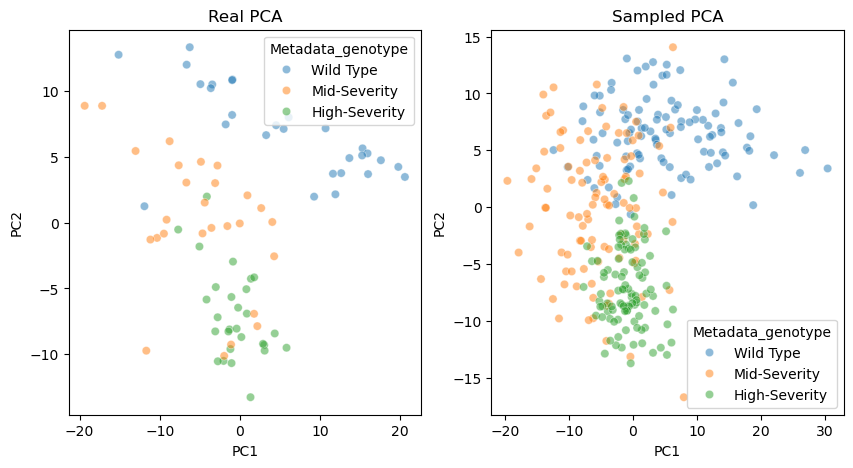

In [16]:
# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sum_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()